#  De belles cartes avec python: mise en pratique



<a href="https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABvisualisation%20maps%C2%BB&security.allowlist.enabled=false)
<br>
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=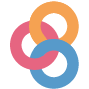)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=/__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![githubdev](https://open.vscode.dev/badges/open-in-vscode.svg)](https://github.dev/linogaliana/python-datascientist//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)

La pratique de la cartographie se fera, dans ce cours, en répliquant des cartes qu'on peut trouver sur
la page de l'*open-data* de la ville de Paris 
[ici](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/information/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name).

Produire de belles cartes demande du temps mais aussi du bon sens. En fonction de la structure des données, certaines représentations sont à éviter voire à exclure. L'excellent guide [disponible ici](https://juliedjidji.github.io/memocarto/semio.html) propose quelques règles et évoque les erreurs à éviter lorsqu'on désire effectuer des
représentations spatiales. 



Ce TP vise à initier:

* Au module graphique de [geopandas](https://geopandas.org/mapping.html) ainsi qu'aux packages [geoplot](https://residentmario.github.io/geoplot/index.html) et
[contextily](https://contextily.readthedocs.io/en/latest/intro_guide.html) pour la construction de cartes figées. `geoplot` est construit sur `seaborn` et constitue ainsi une extension des graphiques de base.
* Au package [folium](https://python-visualization.github.io/folium/) qui est un point d'accès vers la librairie JavaScript [leaflet](https://leafletjs.com/) permettant de produire des cartes interactives

Les données utilisées sont :

* Un sous-ensemble des données de [paris open data](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/information/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name) a été mis à disposition
sur {{< githubrepo >}} pour faciliter l'import (élimination des colonnes
qui ne nous servirons pas mais ralentissent l'import)
* [La localisation précise des stations](https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr)
* [Arrondissements parisiens](https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr)

Dans la première partie, nous allons utiliser les packages suivants:


In [ ]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import geoplot
import matplotlib.pyplot as plt
import folium

Certaines librairies géographiques dépendent de `rtree` qui est parfois difficile à installer. Pour installer `rtree`, le mieux est d'utiliser `anaconda`.

Installations préalables : 


In [ ]:
# Sur anaconda
conda install rtree --yes

In [ ]:
# Sur colab
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas
!pip install geoplot

## Première carte avec l'API `matplotlib` de `geopandas`

{{% box status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 1: Importer les données**

Importer les données de compteurs de vélos en deux temps.

1. D'abord, les comptages peuvent être trouvés à l'adresse <https://github.com/linogaliana/python-datascientist/raw/master/data/bike.csv>. :warning: Il s'agit de données
compressées au format `gzip`, il faut donc utiliser l'option `compression`. Nommer cet objet `comptages`.



2. Importer les données de localisation des compteurs à partir de l'url <https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr>. Nommer cet objet `compteurs`.


3. On va également utiliser les données d'arrondissements de la ville de Paris. Importer ces données depuis <https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr>. Nommer cet objet `arrondissements`.



4. Utiliser la méthode `plot` pour représenter les localisations des compteurs dans l'espace. C'est, on peut l'avouer, peu informatif sans apport extérieur. Il va donc falloir travailler un peu l'esthétique



On serait tenté de faire un *merge* de la base compteurs et comptages. En l'occurrence, il s'agirait d'un produit cartésien puisqu'il s'agit de faire exploser la base spatiale. Avec des données spatiales, c'est souvent une très mauvaise idée. Cela duplique les points, créant des difficultés à représenter les données mais aussi ralentit les calculs. Sauf à utiliser la méthode `dissolve` (qui va agréger *k* fois la même géométrie...), les géométries sont perdues lorsqu'on effectue des `groupby`.  



Maintenant, tout est prêt pour une première carte. `matplotlib` fonctionne selon
le principe des couches. On va de la couche la plus lointaine à celle le plus
en surface. L'exception est lorsqu'on ajoute un fond de carte `contextily` via
`ctx.add_basemap`: on met cet appel en dernier. 

{{% box status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 2: Première carte**

Représenter une carte des `compteurs` avec le fonds de carte des `arrondissements`

  * Faire attention à avoir des arrondissements dont l'intérieur est transparent (argument à utiliser: `facecolor`).
  * Faire des bordures d'arrondissements noires et affichez les compteurs en rouge.
  * Pour obtenir un graphique plus grand, vous pouvez utiliser l'argument `figsize = (10,10)`.
  * Pour les localisations, les points doivent être rouges en étant plus transparent au centre (argument à utiliser: `alpha`) 



Vous devriez obtenir cette carte:




{{% box status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 3 : Ajouter un fonds de carte avec contextily**

Repartir de la carte précédente.

1. Utiliser `ctx.add_basemap` pour ajouter un fonds de carte. Pour ne pas afficher les axes, vous pouvez utiliser `ax.set_axis_off()`.

:warning: *Par défaut, `contextily` désire un système de projection (crs) qui est le Web Mercator (epsg: 3857). Il faut changer la valeur de l'argument `crs`.*

:warning: *Avec les versions anciennes des packages, il faut utiliser `.to_string` sur un objet CRS pour qu'il soit reconnu par `contextily`. Sur des versions récentes, la valeur numérique du code EPSG est suffisante.*




2. Trouver un fonds de carte plus esthétique, qui permette de visualiser les grands axes, parmi ceux possibles. Pour tester l'esthétique, vous pouvez utiliser [cet url](http://leaflet-extras.github.io/leaflet-providers/preview/index.html). La documentation de référence sur les tuiles disponibles est [ici](https://contextily.readthedocs.io/en/latest/providers_deepdive.html) 


Le principe de la *heatmap* est de construire, à partir d'un nuage de point bidimensionnel, une distribution 2D lissée. La méthode repose sur les estimateurs à noyaux qui sont des méthodes de lissage local. 


Pour le moment, la fonction  `geoplot.kdeplot` n'incorpore pas toutes les fonctionalités de `seaborn.kdeplot`. Pour être en mesure de construire une `heatmap` avec des données pondérées (cf. [cette issue dans le dépôt seaborn](https://github.com/mwaskom/seaborn/issues/1364)), il y a une astuce. Il faut simuler *k* points de valeur 1 autour de la localisation observée. La fonction ci-dessous, qui m'a été bien utile, est pratique


In [ ]:
import numpy as np
def expand_points(shapefile,
                  index_var = "grid_id",
                  weight_var = 'prop',
                  radius_sd = 100,
                  crs = 2154):
    """
    Multiply number of points to be able to have a weighted heatmap
    :param shapefile: Shapefile to consider
    :param index_var: Variable name to set index
    :param weight_var: Variable that should be used
    :param radius_sd: Standard deviation for the radius of the jitter
    :param crs: Projection system that should be used. Recommended option
      is Lambert 93 because points will be jitterized using meters
    :return:
      A geopandas point object with as many points by index as weight
    """

    shpcopy = shapefile
    shpcopy = shpcopy.set_index(index_var)
    shpcopy['npoints'] = np.ceil(shpcopy[weight_var])
    shpcopy['geometry'] = shpcopy['geometry'].centroid
    shpcopy['x'] = shpcopy.geometry.x
    shpcopy['y'] = shpcopy.geometry.y
    shpcopy = shpcopy.to_crs(crs)
    shpcopy = shpcopy.loc[np.repeat(shpcopy.index.values, shpcopy.npoints)]
    shpcopy['x'] = shpcopy['x'] + np.random.normal(0, radius_sd, shpcopy.shape[0])
    shpcopy['y'] = shpcopy['y'] + np.random.normal(0, radius_sd, shpcopy.shape[0])

    gdf = gpd.GeoDataFrame(
        shpcopy,
        geometry = gpd.points_from_xy(shpcopy.x, shpcopy.y),
        crs = crs)

    return gdf

{{% box status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 4 : Data cleaning avant de pouvoir faire une heatmap**

1. Calculer le trafic moyen, pour chaque station, entre 7 heures et 10 heures (bornes incluses) et nommer cet objet `df1`. Faire la même chose, en nommant `df2`, pour le trafic entre 17 et 20 heures (bornes incluses)



2. Nous allons désormais préparer les données de manière à faire une heatmap. Après avoir compris ce que permet de faire la fonction `expand_points` ci-dessus, créer une fonction `explode_data` qui suive les étapes suivantes. 
  + Convertir un DataFrame dans le système de projection Lambert 93 (epsg: 2154)
  + Appliquer `expand_points` aux noms de variable adéquats. Vous pouvez fixer la valeur de `radius_sd` à `100`. 
  + Reconvertir l'output au format WGS84 (epsg: 4326)



3. Appliquer cette fonction à `df1` et `df2`





**Exercice 5 : Heatmap, enfin !**

Représenter, pour ces deux moments de la journée, la `heatmap` du trafic de vélo avec `geoplot.kdeplot`. Pour cela :

- Appliquer la fonction `geoplot.kdeplot` avec comme consignes :
    + d'utiliser les arguments `shade=True` et `shade_lowest=True` pour colorer l'intérieur des courbes de niveaux obtenues ; 
    + d'utiliser une palette de couleur rouge avec une transparence modérée (`alpha = 0.6`)
    + d'utiliser l'argument `clip` pour ne pas déborder hors de Paris (en cas de doute, se référer à l'aide de `geoplot.kdeplot`)
    + L'argument `bw` (pour *bandwidth*) détermine le plus ou moins fort lissage spatial. Vous pouvez partir d'un bandwidth égal à 0.01 et le faire varier pour voir l'effet sur le résultat 
    
- Ne pas oublier d'ajouter les arrondissements. Avec `geoplot`, il faut utiliser `geoplot.polyplot`. 







## Des cartes réactives grâce à `folium`

De plus en plus de données de visualisation reposent sur la cartographie réactive. Que ce soit dans l'exploration des données ou dans la représentation finale de résultats, la cartographie réactive est très appréciable. 

`folium` offre une interface très flexible et très facile à prendre à main. Les cartes sont construites grâce à la librairie JavaScript `Leaflet.js` mais, sauf si on désire aller loin dans la customisation du résultat, il n'est pas nécessaire d'avoir des notions dans le domaine. 

Un objet folium se construit par couche. La première est l'initialisation de la carte. Les couches suivantes sont les éléments à mettre en valeur. L'initialisation de la carte nécessite la définition d'un point central (paramètre `location`) et d'un zoom de départ (`zoom_start`). Plutôt que de fournir manuellement le point central et le zoom on peut :

1. Déterminer le point central en construisant des colonnes longitudes et latitudes et en prenant la moyenne de celles-ci ;
2. Utiliser la méthode `fit_bounds` qui cale la carte sur les coins sud-ouest et nord-est. En supposant que la carte s'appelle `m`, on fera `m.fit_bounds([sw, ne])`

Le bout de code suivant permet de calculer le centre de la carte


In [ ]:
compteurs['lon'] = compteurs.geometry.x
compteurs['lat'] = compteurs.geometry.y
center = compteurs[['lat', 'lon']].mean().values.tolist()
print(center)

```
## [48.85598761616161, 2.3432322626262625]
```

Alors que le code suivant permet de calculer les coins:


In [ ]:
sw = compteurs[['lat', 'lon']].min().values.tolist()
ne = compteurs[['lat', 'lon']].max().values.tolist()
print(sw)

```
## [48.82024, 2.26542]
```

In [ ]:
print(ne)

```
## [48.89696, 2.40969]
```

Si un fond gris s'affiche, c'est qu'il y a un problème de localisation. Cela provient généralement d'un problème de projection ou d'une inversion des longitudes et latitudes. 

Les longitudes représentent les *x* (axe ouest-est) et les latitudes *y* (axe sud-nord). De manière contrintuitive, `folium` attend qu'on lui fournisse les données sous la forme `[latitude, longitude]` donc `[y,x]`


**Exercice 6 : Visualiser la localisation des stations**

1. Calculer le centre `center`de la carte des données `compteurs`. Il s'obtient en agrègeant l'ensemble des géométries, calculant le centroid et récupèrant la valeur sous forme de liste. Avec une logique similaire, calculez les bornes du sud-ouest `sw` et du nord-est `ne` de la carte. 


2. Représenter la localisation des stations en utilisant un zoom optimal. 





La carte obtenue doit ressembler à la suivante:

<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><span style="color:#565656">Make this Notebook Trusted to load map: File -> Trust Notebook</span><iframe src="about:blank" style="position:absolute;width:100%;height:100%;left:0;top:0;border:none !important;" data-html=%3C%21DOCTYPE%20html%3E%0A%3Chead%3E%20%20%20%20%0A%20%20%20%20%3Cmeta%20http-equiv%3D%22content-type%22%20content%3D%22text/html%3B%20charset%3DUTF-8%22%20/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%3Cscript%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20L_NO_TOUCH%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20L_DISABLE_3D%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%3C/script%3E%0A%20%20%20%20%0A%20%20%20%20%3Cstyle%3Ehtml%2C%20body%20%7Bwidth%3A%20100%25%3Bheight%3A%20100%25%3Bmargin%3A%200%3Bpadding%3A%200%3B%7D%3C/style%3E%0A%20%20%20%20%3Cstyle%3E%23map%20%7Bposition%3Aabsolute%3Btop%3A0%3Bbottom%3A0%3Bright%3A0%3Bleft%3A0%3B%7D%3C/style%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//code.jquery.com/jquery-1.12.4.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js%22%3E%3C/script%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css%22/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cmeta%20name%3D%22viewport%22%20content%3D%22width%3Ddevice-width%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20initial-scale%3D1.0%2C%20maximum-scale%3D1.0%2C%20user-scalable%3Dno%22%20/%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cstyle%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%23map_2d3294e40cc747bbb792029ac91105b8%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20position%3A%20relative%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20width%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20height%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20left%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20top%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C/style%3E%0A%20%20%20%20%20%20%20%20%0A%3C/head%3E%0A%3Cbody%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cdiv%20class%3D%22folium-map%22%20id%3D%22map_2d3294e40cc747bbb792029ac91105b8%22%20%3E%3C/div%3E%0A%20%20%20%20%20%20%20%20%0A%3C/body%3E%0A%3Cscript%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20map_2d3294e40cc747bbb792029ac91105b8%20%3D%20L.map%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22map_2d3294e40cc747bbb792029ac91105b8%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20center%3A%20%5B48.85598761616161%2C%202.3432322626262625%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20crs%3A%20L.CRS.EPSG3857%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoom%3A%2010%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoomControl%3A%20true%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20preferCanvas%3A%20false%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%0A%20%20%20%20%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20tile_layer_7853c7c433e74513897b518310fb9a5a%20%3D%20L.tileLayer%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22https%3A//stamen-tiles-%7Bs%7D.a.ssl.fastly.net/toner/%7Bz%7D/%7Bx%7D/%7By%7D.png%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22attribution%22%3A%20%22Map%20tiles%20by%20%5Cu003ca%20href%3D%5C%22http%3A//stamen.com%5C%22%5Cu003eStamen%20Design%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//creativecommons.org/licenses/by/3.0%5C%22%5Cu003eCC%20BY%203.0%5Cu003c/a%5Cu003e.%20Data%20by%20%5Cu0026copy%3B%20%5Cu003ca%20href%3D%5C%22http%3A//openstreetmap.org%5C%22%5Cu003eOpenStreetMap%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//www.openstreetmap.org/copyright%5C%22%5Cu003eODbL%5Cu003c/a%5Cu003e.%22%2C%20%22detectRetina%22%3A%20false%2C%20%22maxNativeZoom%22%3A%2018%2C%20%22maxZoom%22%3A%2018%2C%20%22minZoom%22%3A%200%2C%20%22noWrap%22%3A%20false%2C%20%22opacity%22%3A%201%2C%20%22subdomains%22%3A%20%22abc%22%2C%20%22tms%22%3A%20false%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_02522d2de8b24e5cbb6e30f9518998f2%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83511%2C%202.33338%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5f6701fe178a4e668e4e092187fd12b5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9bfeaaa52b274f19a856e910b6211992%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9bfeaaa52b274f19a856e910b6211992%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E97%20avenue%20Denfert%20Rochereau%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5f6701fe178a4e668e4e092187fd12b5.setContent%28html_9bfeaaa52b274f19a856e910b6211992%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_02522d2de8b24e5cbb6e30f9518998f2.bindPopup%28popup_5f6701fe178a4e668e4e092187fd12b5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_cfbceec743b742d2a432bc1d8d853324%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87773%2C%202.3506%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ea81fa920036426a85d382cd2fd83768%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1731ba91a65446e381a88476c0eddcf8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1731ba91a65446e381a88476c0eddcf8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E105%20rue%20La%20Fayette%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ea81fa920036426a85d382cd2fd83768.setContent%28html_1731ba91a65446e381a88476c0eddcf8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_cfbceec743b742d2a432bc1d8d853324.bindPopup%28popup_ea81fa920036426a85d382cd2fd83768%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_2c5e58079cb940a983c0ae477fb2d0b2%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83521%2C%202.33307%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a1ed402e94204707835a7bc5accc8221%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_cc4e21e603754b7ebe008ee2db033252%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_cc4e21e603754b7ebe008ee2db033252%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E106%20avenue%20Denfert%20Rochereau%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a1ed402e94204707835a7bc5accc8221.setContent%28html_cc4e21e603754b7ebe008ee2db033252%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_2c5e58079cb940a983c0ae477fb2d0b2.bindPopup%28popup_a1ed402e94204707835a7bc5accc8221%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_8969dfb9c08847fc8bda1697168ee0f4%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87813%2C%202.3497%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_544bafbdb3d54c6d86b9eb27ce72809e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9e3c4c73b5e8415b865d0b16a459134e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9e3c4c73b5e8415b865d0b16a459134e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E100%20rue%20La%20Fayette%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_544bafbdb3d54c6d86b9eb27ce72809e.setContent%28html_9e3c4c73b5e8415b865d0b16a459134e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_8969dfb9c08847fc8bda1697168ee0f4.bindPopup%28popup_544bafbdb3d54c6d86b9eb27ce72809e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_86bdd20b1f504f9aaa86cf725f535685%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.843435%2C%202.383378%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1edae25a59f54143825d4e0704b3b6b9%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1f7c48a7bcee4a058461e68ebbd9e388%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1f7c48a7bcee4a058461e68ebbd9e388%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E135%20avenue%20Daumesnil%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1edae25a59f54143825d4e0704b3b6b9.setContent%28html_1f7c48a7bcee4a058461e68ebbd9e388%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_86bdd20b1f504f9aaa86cf725f535685.bindPopup%28popup_1edae25a59f54143825d4e0704b3b6b9%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_270699416ef24c0cad0475fcbd6b99e9%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9f7ecccdc743455ab92ac4aa37e53d8b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_abe33f604cb4422ca64018ce78a3df82%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_abe33f604cb4422ca64018ce78a3df82%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9f7ecccdc743455ab92ac4aa37e53d8b.setContent%28html_abe33f604cb4422ca64018ce78a3df82%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_270699416ef24c0cad0475fcbd6b99e9.bindPopup%28popup_9f7ecccdc743455ab92ac4aa37e53d8b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_9edc2bacaafc4c2dbaa634a41f569f9a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b196139ea6e14f6eb5d23302cbdf32bc%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_14abe5230a294c9182943a91262127e9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_14abe5230a294c9182943a91262127e9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b196139ea6e14f6eb5d23302cbdf32bc.setContent%28html_14abe5230a294c9182943a91262127e9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_9edc2bacaafc4c2dbaa634a41f569f9a.bindPopup%28popup_b196139ea6e14f6eb5d23302cbdf32bc%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_086fa8babbbc4047b29a44c93e6d81eb%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b87a36687fe2413597825f56077544f7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1c993154d46e4a76891bc098d8e8ada0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1c993154d46e4a76891bc098d8e8ada0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b87a36687fe2413597825f56077544f7.setContent%28html_1c993154d46e4a76891bc098d8e8ada0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_086fa8babbbc4047b29a44c93e6d81eb.bindPopup%28popup_b87a36687fe2413597825f56077544f7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a0d2f6dca27942b196035ae415f5c2ad%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e9f0500fd249413d9fc10adc6d7a7da1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0b41aaefa81f4e5683b6ff9d2e2286f9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0b41aaefa81f4e5683b6ff9d2e2286f9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e9f0500fd249413d9fc10adc6d7a7da1.setContent%28html_0b41aaefa81f4e5683b6ff9d2e2286f9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a0d2f6dca27942b196035ae415f5c2ad.bindPopup%28popup_e9f0500fd249413d9fc10adc6d7a7da1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_da2b31c2289a4759a6137217a6848c82%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_02a1bf6a143e40e8987f172628256983%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2a48e1a1dc834a00b95d238ab8f8908b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2a48e1a1dc834a00b95d238ab8f8908b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_02a1bf6a143e40e8987f172628256983.setContent%28html_2a48e1a1dc834a00b95d238ab8f8908b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_da2b31c2289a4759a6137217a6848c82.bindPopup%28popup_02a1bf6a143e40e8987f172628256983%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b16dcd34419c4977b91763b84f202e6a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_00e27bd7c927454ca1837022ba54af4c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2a9931008bde4586b57bc3b58ff0e094%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2a9931008bde4586b57bc3b58ff0e094%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_00e27bd7c927454ca1837022ba54af4c.setContent%28html_2a9931008bde4586b57bc3b58ff0e094%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b16dcd34419c4977b91763b84f202e6a.bindPopup%28popup_00e27bd7c927454ca1837022ba54af4c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_e61949a24d7f40408ae57798158ebd4a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846099%2C%202.375456%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4ea9afcb4c294cba8add4fb56512da60%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ce8ba1507abf49d98b787967db48863a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ce8ba1507abf49d98b787967db48863a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20boulevard%20Diderot%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4ea9afcb4c294cba8add4fb56512da60.setContent%28html_ce8ba1507abf49d98b787967db48863a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_e61949a24d7f40408ae57798158ebd4a.bindPopup%28popup_4ea9afcb4c294cba8add4fb56512da60%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_91faf606498c477abe1c30668f777cb6%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ad4103d860fa46e89171ec68b56d87bd%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_65b8e9471be8449b8059f764f46cc26a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_65b8e9471be8449b8059f764f46cc26a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ad4103d860fa46e89171ec68b56d87bd.setContent%28html_65b8e9471be8449b8059f764f46cc26a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_91faf606498c477abe1c30668f777cb6.bindPopup%28popup_ad4103d860fa46e89171ec68b56d87bd%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_5417eeb79f074726a53cf9f1640c407f%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2c5f6638c9b64ef4b8ff4765b3e14bf1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c23099632d4949129ef1c4c39fc570ba%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c23099632d4949129ef1c4c39fc570ba%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2c5f6638c9b64ef4b8ff4765b3e14bf1.setContent%28html_c23099632d4949129ef1c4c39fc570ba%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_5417eeb79f074726a53cf9f1640c407f.bindPopup%28popup_2c5f6638c9b64ef4b8ff4765b3e14bf1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_19c63699bf61460b94e6b25e63708908%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86149%2C%202.37376%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1c622a3117a74fcbab184c4d24746c4a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2fbe4051f637460e8b631c919884ce90%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2fbe4051f637460e8b631c919884ce90%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E67%20boulevard%20Voltaire%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1c622a3117a74fcbab184c4d24746c4a.setContent%28html_2fbe4051f637460e8b631c919884ce90%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_19c63699bf61460b94e6b25e63708908.bindPopup%28popup_1c622a3117a74fcbab184c4d24746c4a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_cb261a66aa544352a3dbe0f51abaf19a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.874716%2C%202.292439%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_229e9f42b8b34be2be8599f65084fb90%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e88ab2b9bde840d9b5a30ee061f314e7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e88ab2b9bde840d9b5a30ee061f314e7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_229e9f42b8b34be2be8599f65084fb90.setContent%28html_e88ab2b9bde840d9b5a30ee061f314e7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_cb261a66aa544352a3dbe0f51abaf19a.bindPopup%28popup_229e9f42b8b34be2be8599f65084fb90%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_38df7dc5e5fc40938cc52f4dc9597f98%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87451%2C%202.29215%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_20ffeec38d8446d0b08542d15c3a3272%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_603cb12bd3a744c7be0cfb34f763cf27%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_603cb12bd3a744c7be0cfb34f763cf27%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E7%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_20ffeec38d8446d0b08542d15c3a3272.setContent%28html_603cb12bd3a744c7be0cfb34f763cf27%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_38df7dc5e5fc40938cc52f4dc9597f98.bindPopup%28popup_20ffeec38d8446d0b08542d15c3a3272%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_119d22c23ece4a039b5d7fc3bc38db85%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86155%2C%202.37407%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_33d9eb03df6844c7a040df8bca1a28d3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a40a5c3280d146fd8d1ecd374a73e60c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a40a5c3280d146fd8d1ecd374a73e60c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Voltaire%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_33d9eb03df6844c7a040df8bca1a28d3.setContent%28html_a40a5c3280d146fd8d1ecd374a73e60c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_119d22c23ece4a039b5d7fc3bc38db85.bindPopup%28popup_33d9eb03df6844c7a040df8bca1a28d3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a1b60c9468d047c3961fccde3aa1a156%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87756%2C%202.35535%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8b735a39932f4031a403214ceb007050%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_879d4ab519884a77ab32e57b7013cc72%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_879d4ab519884a77ab32e57b7013cc72%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E89%20boulevard%20de%20Magenta%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8b735a39932f4031a403214ceb007050.setContent%28html_879d4ab519884a77ab32e57b7013cc72%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a1b60c9468d047c3961fccde3aa1a156.bindPopup%28popup_8b735a39932f4031a403214ceb007050%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c3f12fe8740e4113972412f7a2983035%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88181%2C%202.281546%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f134785afd54400a9048136bc874b2a4%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7b24350b0f134d8e825997b9a20f9f56%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7b24350b0f134d8e825997b9a20f9f56%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E16%20avenue%20de%20la%20Porte%20des%20Ternes%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f134785afd54400a9048136bc874b2a4.setContent%28html_7b24350b0f134d8e825997b9a20f9f56%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c3f12fe8740e4113972412f7a2983035.bindPopup%28popup_f134785afd54400a9048136bc874b2a4%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_01b7f9b7013d4be682886732b6ffbf3c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84015%2C%202.26733%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0d2c6df1f61542beb1d06a6cad0f098f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1dbadbb371ca4b12bb297376b7f53a23%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1dbadbb371ca4b12bb297376b7f53a23%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0d2c6df1f61542beb1d06a6cad0f098f.setContent%28html_1dbadbb371ca4b12bb297376b7f53a23%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_01b7f9b7013d4be682886732b6ffbf3c.bindPopup%28popup_0d2c6df1f61542beb1d06a6cad0f098f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_7bda5cfa2de94da2a4ffa46734ce3dc8%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.877726%2C%202.354926%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_70f3368177b645768178d583a2cb64eb%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e8180b77c4cd48e39f19dcca3ae37f92%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e8180b77c4cd48e39f19dcca3ae37f92%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E102%20boulevard%20de%20Magenta%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_70f3368177b645768178d583a2cb64eb.setContent%28html_e8180b77c4cd48e39f19dcca3ae37f92%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_7bda5cfa2de94da2a4ffa46734ce3dc8.bindPopup%28popup_70f3368177b645768178d583a2cb64eb%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_d4172ae3d9f7437eb623f70ff8892bea%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86057%2C%202.38886%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c6a4534a038841fa9cd4b52041b381c5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ef7941a3cf1548f0922b8bc91b7cf7fe%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ef7941a3cf1548f0922b8bc91b7cf7fe%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E26%20boulevard%20de%20M%C3%A9nilmontant%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c6a4534a038841fa9cd4b52041b381c5.setContent%28html_ef7941a3cf1548f0922b8bc91b7cf7fe%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_d4172ae3d9f7437eb623f70ff8892bea.bindPopup%28popup_c6a4534a038841fa9cd4b52041b381c5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ae14e812994a4bcbad4ac18580a7dfde%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.881626%2C%202.281203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0d2007786eb54c52bbb776e70c78e252%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a5a75e118bfb4a7ca0d0c2b78144cefe%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a5a75e118bfb4a7ca0d0c2b78144cefe%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2016%20avenue%20de%20la%20%20Porte%20des%20Ternes%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0d2007786eb54c52bbb776e70c78e252.setContent%28html_a5a75e118bfb4a7ca0d0c2b78144cefe%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ae14e812994a4bcbad4ac18580a7dfde.bindPopup%28popup_0d2007786eb54c52bbb776e70c78e252%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c4d2bb4bc926407a9121b44491c7fc52%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830449%2C%202.353199%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_23eeb9710eb84d02a9852ede178c5d3f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_323e6ae41dae473eaa6823bbb58fbc12%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_323e6ae41dae473eaa6823bbb58fbc12%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Auguste%20Blanqui%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_23eeb9710eb84d02a9852ede178c5d3f.setContent%28html_323e6ae41dae473eaa6823bbb58fbc12%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c4d2bb4bc926407a9121b44491c7fc52.bindPopup%28popup_23eeb9710eb84d02a9852ede178c5d3f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_9235747af0c340d6a61fa802cc7544b7%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86077%2C%202.37305%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_727435da74274bc2be74547f434ce0d0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f8f829a036684da295eee662605e73d8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f8f829a036684da295eee662605e73d8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Richard%20Lenoir%20%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_727435da74274bc2be74547f434ce0d0.setContent%28html_f8f829a036684da295eee662605e73d8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_9235747af0c340d6a61fa802cc7544b7.bindPopup%28popup_727435da74274bc2be74547f434ce0d0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_d3d180aeb6e54b3cafd8978ea9ee6748%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82658%2C%202.38409%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_55d8c9bcb48b4bf793ba389a1fbf28bc%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2c3e3db07a5e4a279bf0ef7a39e06413%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2c3e3db07a5e4a279bf0ef7a39e06413%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_55d8c9bcb48b4bf793ba389a1fbf28bc.setContent%28html_2c3e3db07a5e4a279bf0ef7a39e06413%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_d3d180aeb6e54b3cafd8978ea9ee6748.bindPopup%28popup_55d8c9bcb48b4bf793ba389a1fbf28bc%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_1d9ffa243d774bc7bf2db90086efe607%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1447f2fe76cb4778b136b0d05e458e0e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_eb63adc88c13489fba0f674afc301892%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_eb63adc88c13489fba0f674afc301892%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1447f2fe76cb4778b136b0d05e458e0e.setContent%28html_eb63adc88c13489fba0f674afc301892%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_1d9ffa243d774bc7bf2db90086efe607.bindPopup%28popup_1447f2fe76cb4778b136b0d05e458e0e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a671abaa9d4745918a6126b89488ebee%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_525a80a2c67b41fcb8f979d4dbb95cbf%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_029198f46ae445bdba75c24d133c1aae%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_029198f46ae445bdba75c24d133c1aae%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_525a80a2c67b41fcb8f979d4dbb95cbf.setContent%28html_029198f46ae445bdba75c24d133c1aae%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a671abaa9d4745918a6126b89488ebee.bindPopup%28popup_525a80a2c67b41fcb8f979d4dbb95cbf%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b2475321e81e47b9bf85e93359c6a597%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.860852%2C%202.372279%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fc96aa09faf34f1f97a630782350ba04%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ef4a6ffb90ed423db27cb3c804b430d5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ef4a6ffb90ed423db27cb3c804b430d5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E77%20boulevard%20Richard%20Lenoir%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fc96aa09faf34f1f97a630782350ba04.setContent%28html_ef4a6ffb90ed423db27cb3c804b430d5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b2475321e81e47b9bf85e93359c6a597.bindPopup%28popup_fc96aa09faf34f1f97a630782350ba04%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b128384e2154477880d0b05b7638c935%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e37f29cca5ba49b9963968d5e4fae397%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c6152335a7b94123b241b3d954579bf1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c6152335a7b94123b241b3d954579bf1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e37f29cca5ba49b9963968d5e4fae397.setContent%28html_c6152335a7b94123b241b3d954579bf1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b128384e2154477880d0b05b7638c935.bindPopup%28popup_e37f29cca5ba49b9963968d5e4fae397%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_56cafdb4101c446c866af99a372bcf9c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7ed671a7529a4f6c916d28ed96fb725c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9d03326af4ca4a8aab656de271d6589a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9d03326af4ca4a8aab656de271d6589a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7ed671a7529a4f6c916d28ed96fb725c.setContent%28html_9d03326af4ca4a8aab656de271d6589a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_56cafdb4101c446c866af99a372bcf9c.bindPopup%28popup_7ed671a7529a4f6c916d28ed96fb725c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_1dbb00c1a0fd484b98583b4856fce160%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3e42ff4208d94594bd00bebaaca4656b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_55f1b5b6979f4666a7102eb8f2dab28f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_55f1b5b6979f4666a7102eb8f2dab28f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3e42ff4208d94594bd00bebaaca4656b.setContent%28html_55f1b5b6979f4666a7102eb8f2dab28f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_1dbb00c1a0fd484b98583b4856fce160.bindPopup%28popup_3e42ff4208d94594bd00bebaaca4656b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b8e5a68e3e8b425797fc8673fe8d874d%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2d00245403df433690d3ba55885004ae%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3ccbaff9db0449c9bb28f7aeb73ed54d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3ccbaff9db0449c9bb28f7aeb73ed54d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2d00245403df433690d3ba55885004ae.setContent%28html_3ccbaff9db0449c9bb28f7aeb73ed54d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b8e5a68e3e8b425797fc8673fe8d874d.bindPopup%28popup_2d00245403df433690d3ba55885004ae%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_10a92bd3f1d5491ebcf9eaafc2161057%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_22855401dfcb44d4b0f83d480b249fdf%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_53ef1d0ac19c449da448af5823cec75d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_53ef1d0ac19c449da448af5823cec75d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_22855401dfcb44d4b0f83d480b249fdf.setContent%28html_53ef1d0ac19c449da448af5823cec75d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_10a92bd3f1d5491ebcf9eaafc2161057.bindPopup%28popup_22855401dfcb44d4b0f83d480b249fdf%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_439d13c09e4b4175ae03ea559e49dd10%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9190257b2bcf4dc6a7923ceb9331be8f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3806a19017bc43d29ed4ed5203e6e60b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3806a19017bc43d29ed4ed5203e6e60b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9190257b2bcf4dc6a7923ceb9331be8f.setContent%28html_3806a19017bc43d29ed4ed5203e6e60b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_439d13c09e4b4175ae03ea559e49dd10.bindPopup%28popup_9190257b2bcf4dc6a7923ceb9331be8f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b8b45737cf034fa2b6bd1e6772e7d5ac%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0e5a7c7783f8470baab7a802e5e901f1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_711e71e9e79446f6a2a2d187241eb3c1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_711e71e9e79446f6a2a2d187241eb3c1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0e5a7c7783f8470baab7a802e5e901f1.setContent%28html_711e71e9e79446f6a2a2d187241eb3c1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b8b45737cf034fa2b6bd1e6772e7d5ac.bindPopup%28popup_0e5a7c7783f8470baab7a802e5e901f1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_7a1bd398342e4f05b47e91c596faeea5%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a325ecae10ce4346a68ad74bdaf5a353%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_cbcdfe0a47f043c3afff81e0bed2e40c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_cbcdfe0a47f043c3afff81e0bed2e40c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a325ecae10ce4346a68ad74bdaf5a353.setContent%28html_cbcdfe0a47f043c3afff81e0bed2e40c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_7a1bd398342e4f05b47e91c596faeea5.bindPopup%28popup_a325ecae10ce4346a68ad74bdaf5a353%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_41baae7211f44306904194a9acfd89dc%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82682%2C%202.38465%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_dd0c5bc1daa141dabd608bc2d96f0579%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_bce7da2b18704b33b696bdb3f6c1aa3c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_bce7da2b18704b33b696bdb3f6c1aa3c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_dd0c5bc1daa141dabd608bc2d96f0579.setContent%28html_bce7da2b18704b33b696bdb3f6c1aa3c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_41baae7211f44306904194a9acfd89dc.bindPopup%28popup_dd0c5bc1daa141dabd608bc2d96f0579%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_e5277eee0c9146288d075e2dfa9a45b0%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83992%2C%202.26694%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_de80feb369364a2a9d78f0c2fa692be7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_cf9ed0d5b5f2406e8a4354c2a918ef28%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_cf9ed0d5b5f2406e8a4354c2a918ef28%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_de80feb369364a2a9d78f0c2fa692be7.setContent%28html_cf9ed0d5b5f2406e8a4354c2a918ef28%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_e5277eee0c9146288d075e2dfa9a45b0.bindPopup%28popup_de80feb369364a2a9d78f0c2fa692be7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_5bb3b73db075423396995fc2b8b1a5a7%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.840801%2C%202.333233%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1535047537f94a3abb92e66fd4310ae6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_bed702fefebe43e88b7d45754ab0a119%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_bed702fefebe43e88b7d45754ab0a119%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E152%20boulevard%20du%20Montparnasse%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1535047537f94a3abb92e66fd4310ae6.setContent%28html_bed702fefebe43e88b7d45754ab0a119%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_5bb3b73db075423396995fc2b8b1a5a7.bindPopup%28popup_1535047537f94a3abb92e66fd4310ae6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_2ace64d5e9f84f41a3ced17a69e16699%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.840801%2C%202.333233%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f53021019aa34228a1bb722d98a67b6d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f60bb47e425647e18d2d78e3e8214754%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f60bb47e425647e18d2d78e3e8214754%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E152%20boulevard%20du%20Montparnasse%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f53021019aa34228a1bb722d98a67b6d.setContent%28html_f60bb47e425647e18d2d78e3e8214754%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_2ace64d5e9f84f41a3ced17a69e16699.bindPopup%28popup_f53021019aa34228a1bb722d98a67b6d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_42e08567891d4682b118c26a920ef5a4%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83068%2C%202.35348%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cdfada46db7e41a3ba2613ed7ab0601f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a0b65e6cbf4048b59f6192b735e0bfc7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a0b65e6cbf4048b59f6192b735e0bfc7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20boulevard%20Auguste%20Blanqui%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cdfada46db7e41a3ba2613ed7ab0601f.setContent%28html_a0b65e6cbf4048b59f6192b735e0bfc7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_42e08567891d4682b118c26a920ef5a4.bindPopup%28popup_cdfada46db7e41a3ba2613ed7ab0601f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b4ba09f73e8e4cf1826c81516f5604b2%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86179%2C%202.32014%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_aa58cdfed6e848fea5abbdf61b817efc%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6f8e9d84e9944312adba61d7bd3d8e54%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6f8e9d84e9944312adba61d7bd3d8e54%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E243%20boulevard%20Saint%20Germain%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_aa58cdfed6e848fea5abbdf61b817efc.setContent%28html_6f8e9d84e9944312adba61d7bd3d8e54%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b4ba09f73e8e4cf1826c81516f5604b2.bindPopup%28popup_aa58cdfed6e848fea5abbdf61b817efc%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b001dcfbef6b4aa3b6c066e19e98511b%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c63787a9e0aa444392896b21d76f97e3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4fe486edf3cd41e4a29ecf4e59ac8c73%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4fe486edf3cd41e4a29ecf4e59ac8c73%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c63787a9e0aa444392896b21d76f97e3.setContent%28html_4fe486edf3cd41e4a29ecf4e59ac8c73%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b001dcfbef6b4aa3b6c066e19e98511b.bindPopup%28popup_c63787a9e0aa444392896b21d76f97e3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_26b5896d5d2a46c9bce6203a8850a6c4%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_65fed508ff684a48a35d76c30ffef54a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ad2936ac89c8456791f50df1f7fef471%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ad2936ac89c8456791f50df1f7fef471%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_65fed508ff684a48a35d76c30ffef54a.setContent%28html_ad2936ac89c8456791f50df1f7fef471%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_26b5896d5d2a46c9bce6203a8850a6c4.bindPopup%28popup_65fed508ff684a48a35d76c30ffef54a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_270ac4a2d19f41a0a161abe08945d919%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88926%2C%202.37472%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e80b2d67e3cd4020bdb00067b702f959%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b860290dc7634894bd08082d5e3171b3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b860290dc7634894bd08082d5e3171b3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E87%20avenue%20de%20Flandre%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e80b2d67e3cd4020bdb00067b702f959.setContent%28html_b860290dc7634894bd08082d5e3171b3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_270ac4a2d19f41a0a161abe08945d919.bindPopup%28popup_e80b2d67e3cd4020bdb00067b702f959%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c1119e7aacd04ad5991fadf623ded438%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.889046%2C%202.374872%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_767e30f1978644ecb8f070db9ae5b8f9%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d3611d05cd6c497caac9551b9f27f9db%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d3611d05cd6c497caac9551b9f27f9db%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20avenue%20de%20Flandre%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_767e30f1978644ecb8f070db9ae5b8f9.setContent%28html_d3611d05cd6c497caac9551b9f27f9db%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c1119e7aacd04ad5991fadf623ded438.bindPopup%28popup_767e30f1978644ecb8f070db9ae5b8f9%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_3d6e746e6703466caf94ad13343b36b4%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86357%2C%202.32203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6328dd2d68cc4af4b2762da565e9715d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_febd78fea1a14c1ba4c9060a82ef681b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_febd78fea1a14c1ba4c9060a82ef681b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20des%20Tuileries%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6328dd2d68cc4af4b2762da565e9715d.setContent%28html_febd78fea1a14c1ba4c9060a82ef681b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_3d6e746e6703466caf94ad13343b36b4.bindPopup%28popup_6328dd2d68cc4af4b2762da565e9715d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_07004481fe57474483bd2f350569f893%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86357%2C%202.32203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5f5e052c4ee140709bc066f33c6e5b73%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_522fff62b82b40398ea40fdd7b028d10%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_522fff62b82b40398ea40fdd7b028d10%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20des%20Tuileries%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5f5e052c4ee140709bc066f33c6e5b73.setContent%28html_522fff62b82b40398ea40fdd7b028d10%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_07004481fe57474483bd2f350569f893.bindPopup%28popup_5f5e052c4ee140709bc066f33c6e5b73%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_8e0f652ce64448258e6f9b5e517f724d%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86451%2C%202.40932%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6b2a7de42a664d8ebb0d55e4c6a0a62d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_87e039ab88094b7883c81b2b8ab7d1fa%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_87e039ab88094b7883c81b2b8ab7d1fa%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E2%20avenue%20de%20la%20Porte%20de%20Bagnolet%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6b2a7de42a664d8ebb0d55e4c6a0a62d.setContent%28html_87e039ab88094b7883c81b2b8ab7d1fa%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_8e0f652ce64448258e6f9b5e517f724d.bindPopup%28popup_6b2a7de42a664d8ebb0d55e4c6a0a62d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_4221f4ea30844dc1a717f89f03ec28fd%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869873%2C%202.307419%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0c7c2856bf0d438db0818d75f9424039%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ba1baea9f49044eabbdc0d1fcfd142e7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ba1baea9f49044eabbdc0d1fcfd142e7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E44%20avenue%20des%20Champs%20Elys%C3%A9es%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0c7c2856bf0d438db0818d75f9424039.setContent%28html_ba1baea9f49044eabbdc0d1fcfd142e7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_4221f4ea30844dc1a717f89f03ec28fd.bindPopup%28popup_0c7c2856bf0d438db0818d75f9424039%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_527c282bdcca41a7afbc6e2d7e833e58%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82024%2C%202.35902%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a45f73a1006f40aab6fd8c937bb632c5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e571fd6959054357a0bed5a3c4767121%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e571fd6959054357a0bed5a3c4767121%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E180%20avenue%20d%27Italie%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a45f73a1006f40aab6fd8c937bb632c5.setContent%28html_e571fd6959054357a0bed5a3c4767121%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_527c282bdcca41a7afbc6e2d7e833e58.bindPopup%28popup_a45f73a1006f40aab6fd8c937bb632c5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_8582faf39f6643dcb2fb61176789cc6c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.842091%2C%202.301%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5e782e71b37449da96114ce629a9cb3d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d730d1119c844f6c97070a7631c9c04b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d730d1119c844f6c97070a7631c9c04b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E129%20rue%20Lecourbe%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5e782e71b37449da96114ce629a9cb3d.setContent%28html_d730d1119c844f6c97070a7631c9c04b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_8582faf39f6643dcb2fb61176789cc6c.bindPopup%28popup_5e782e71b37449da96114ce629a9cb3d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_50287394271f4d76a7b60a6ca528572a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82026%2C%202.3592%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4dc7c1bdcd3d49278094590584c45db3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3672d4d75fc4405b9893c21134b99825%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3672d4d75fc4405b9893c21134b99825%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E147%20avenue%20d%27Italie%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4dc7c1bdcd3d49278094590584c45db3.setContent%28html_3672d4d75fc4405b9893c21134b99825%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_50287394271f4d76a7b60a6ca528572a.bindPopup%28popup_4dc7c1bdcd3d49278094590584c45db3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_7b7ff22cd4af4cd0a2b7b56eb5a6a482%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869831%2C%202.307076%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b2db91aba2364853a111352e19a6ad53%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_75e3e7c3df7e431eadca28e1a9f842d4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_75e3e7c3df7e431eadca28e1a9f842d4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E33%20avenue%20des%20Champs%20Elys%C3%A9es%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b2db91aba2364853a111352e19a6ad53.setContent%28html_75e3e7c3df7e431eadca28e1a9f842d4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_7b7ff22cd4af4cd0a2b7b56eb5a6a482.bindPopup%28popup_b2db91aba2364853a111352e19a6ad53%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_2640cc28217245c6999ac9eb64798528%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84216%2C%202.30115%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_bf0f4f4c73c8452da055277f2b541092%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e164561417304f51857a6fb03137edf7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e164561417304f51857a6fb03137edf7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E132%20rue%20Lecourbe%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_bf0f4f4c73c8452da055277f2b541092.setContent%28html_e164561417304f51857a6fb03137edf7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_2640cc28217245c6999ac9eb64798528.bindPopup%28popup_bf0f4f4c73c8452da055277f2b541092%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ec10e6357ad645da94a82e429106b3e0%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86373%2C%202.31973%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f7aa91f6c3304a8a96871f4d3b1a8ba0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7814e10e9e594f3183d460584f40ebbe%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7814e10e9e594f3183d460584f40ebbe%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f7aa91f6c3304a8a96871f4d3b1a8ba0.setContent%28html_7814e10e9e594f3183d460584f40ebbe%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ec10e6357ad645da94a82e429106b3e0.bindPopup%28popup_f7aa91f6c3304a8a96871f4d3b1a8ba0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b6819e6f134845f29b9d4204c6bd6328%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86282%2C%202.31061%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4c603e273d374eb580c8764f2379d853%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1fd6eb3a23e6471a9b8c5aaeadc12a68%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1fd6eb3a23e6471a9b8c5aaeadc12a68%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4c603e273d374eb580c8764f2379d853.setContent%28html_1fd6eb3a23e6471a9b8c5aaeadc12a68%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b6819e6f134845f29b9d4204c6bd6328.bindPopup%28popup_4c603e273d374eb580c8764f2379d853%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_8d2d13b8ae9f4b3e999539cedef103f2%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86378%2C%202.32003%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6c07789f6cad468b85d5df4ee93271c2%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_911c871749fb418ea558324581a611be%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_911c871749fb418ea558324581a611be%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6c07789f6cad468b85d5df4ee93271c2.setContent%28html_911c871749fb418ea558324581a611be%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_8d2d13b8ae9f4b3e999539cedef103f2.bindPopup%28popup_6c07789f6cad468b85d5df4ee93271c2%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_0159b6cbbcc647429fdf221ac40fd997%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86284%2C%202.310345%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_15dfb95944604254b164d49b374dae84%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_07f32da6617e43f99a72dd52ac07122d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_07f32da6617e43f99a72dd52ac07122d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_15dfb95944604254b164d49b374dae84.setContent%28html_07f32da6617e43f99a72dd52ac07122d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_0159b6cbbcc647429fdf221ac40fd997.bindPopup%28popup_15dfb95944604254b164d49b374dae84%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_87b7da3b4f6f492bb41330a9032d6322%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82108%2C%202.32537%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8907fcd8c3d8461b983996d95d26c4d6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e2deff3c41984aee8b71a08c7073bf3b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e2deff3c41984aee8b71a08c7073bf3b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E3%20avenue%20de%20la%20Porte%20D%27Orl%C3%A9ans%20%28gare%20routi%C3%A8re%29%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8907fcd8c3d8461b983996d95d26c4d6.setContent%28html_e2deff3c41984aee8b71a08c7073bf3b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_87b7da3b4f6f492bb41330a9032d6322.bindPopup%28popup_8907fcd8c3d8461b983996d95d26c4d6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_1b456bb8df7340619856adf8d247f94c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_86727f2c2024445383689667baf1b79f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_fb7e166d564e49b992360151e9167d48%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_fb7e166d564e49b992360151e9167d48%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_86727f2c2024445383689667baf1b79f.setContent%28html_fb7e166d564e49b992360151e9167d48%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_1b456bb8df7340619856adf8d247f94c.bindPopup%28popup_86727f2c2024445383689667baf1b79f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ad96467b797e4a779ac32b75b34a28c2%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_bb66e8d051d44b04a54f767ffaac843f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_86aa1ccce1124652ab4f3694d834134a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_86aa1ccce1124652ab4f3694d834134a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_bb66e8d051d44b04a54f767ffaac843f.setContent%28html_86aa1ccce1124652ab4f3694d834134a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ad96467b797e4a779ac32b75b34a28c2.bindPopup%28popup_bb66e8d051d44b04a54f767ffaac843f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ffc5faacbf21464f8d299db4fb670f41%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_884fe428271b44bda7875f680d28a16d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d6d157833aba4a7b9e58f6ab5aed2abc%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d6d157833aba4a7b9e58f6ab5aed2abc%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_884fe428271b44bda7875f680d28a16d.setContent%28html_d6d157833aba4a7b9e58f6ab5aed2abc%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ffc5faacbf21464f8d299db4fb670f41.bindPopup%28popup_884fe428271b44bda7875f680d28a16d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_fc58af35658d4eca8d8561d51f28986e%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6fedec330774490d98a692f44c0a2a55%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_912cca2cca8240eb9d067e45d85920ef%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_912cca2cca8240eb9d067e45d85920ef%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6fedec330774490d98a692f44c0a2a55.setContent%28html_912cca2cca8240eb9d067e45d85920ef%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_fc58af35658d4eca8d8561d51f28986e.bindPopup%28popup_6fedec330774490d98a692f44c0a2a55%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c0693c77da604018982733713cd7f57d%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c1c9a0cf6d394a3491918fabd236f31a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a9a62b2fa2fc4b1abd234eb07c8b6bec%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a9a62b2fa2fc4b1abd234eb07c8b6bec%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c1c9a0cf6d394a3491918fabd236f31a.setContent%28html_a9a62b2fa2fc4b1abd234eb07c8b6bec%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c0693c77da604018982733713cd7f57d.bindPopup%28popup_c1c9a0cf6d394a3491918fabd236f31a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c520dd74a80e4f3e89752c287f809108%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fe2ba312a5464671b1b8a50026f25aaa%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_61f021b077b54d03a355cb9e4052517c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_61f021b077b54d03a355cb9e4052517c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fe2ba312a5464671b1b8a50026f25aaa.setContent%28html_61f021b077b54d03a355cb9e4052517c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c520dd74a80e4f3e89752c287f809108.bindPopup%28popup_fe2ba312a5464671b1b8a50026f25aaa%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_f5806974a5354cd4bc92061cfabd25b6%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_35d537203d1e469a9ba7ee842cf09a2c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_af5abfa8d62444479226670386b79868%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_af5abfa8d62444479226670386b79868%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_35d537203d1e469a9ba7ee842cf09a2c.setContent%28html_af5abfa8d62444479226670386b79868%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_f5806974a5354cd4bc92061cfabd25b6.bindPopup%28popup_35d537203d1e469a9ba7ee842cf09a2c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ecc955706324493394ba59f8d3e920c2%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_55743ce07e9f4d239a4664106cd701f6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_bcba3f2c9acc4450833f9d2e9917107e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_bcba3f2c9acc4450833f9d2e9917107e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_55743ce07e9f4d239a4664106cd701f6.setContent%28html_bcba3f2c9acc4450833f9d2e9917107e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ecc955706324493394ba59f8d3e920c2.bindPopup%28popup_55743ce07e9f4d239a4664106cd701f6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_9565372bb50541d4bfd49899bc4415f4%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9c025a646dbd420da5774f1285292a4a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_aa666e71b9a04152a391efdc4771129a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_aa666e71b9a04152a391efdc4771129a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9c025a646dbd420da5774f1285292a4a.setContent%28html_aa666e71b9a04152a391efdc4771129a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_9565372bb50541d4bfd49899bc4415f4.bindPopup%28popup_9c025a646dbd420da5774f1285292a4a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_9693e5bf6a774994aed4d2c99f09d4bd%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8d6914cc71984804bdbe4d5f3d73848a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2a050e4be2c549598b8c3f212312d359%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2a050e4be2c549598b8c3f212312d359%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8d6914cc71984804bdbe4d5f3d73848a.setContent%28html_2a050e4be2c549598b8c3f212312d359%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_9693e5bf6a774994aed4d2c99f09d4bd.bindPopup%28popup_8d6914cc71984804bdbe4d5f3d73848a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_2088fe921fc7465b9dd30e3fc033e2ea%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0eeff05086cf4e6bb6020215ae4f7b3b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_463fa2987b7c44d2af2a1617abfb264f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_463fa2987b7c44d2af2a1617abfb264f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0eeff05086cf4e6bb6020215ae4f7b3b.setContent%28html_463fa2987b7c44d2af2a1617abfb264f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_2088fe921fc7465b9dd30e3fc033e2ea.bindPopup%28popup_0eeff05086cf4e6bb6020215ae4f7b3b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_737a4149fc2247db8fc00aec982c4fb0%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cd381625520f42719e50d7ff350108e1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8b08e6c8189840d9927e845936ae6e73%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8b08e6c8189840d9927e845936ae6e73%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cd381625520f42719e50d7ff350108e1.setContent%28html_8b08e6c8189840d9927e845936ae6e73%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_737a4149fc2247db8fc00aec982c4fb0.bindPopup%28popup_cd381625520f42719e50d7ff350108e1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_d2fc961fae7b47efb6aeee4d2f123993%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5f4df96e20a9491784e01c519048caa7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_39133591670f4e299657842782800f87%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_39133591670f4e299657842782800f87%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5f4df96e20a9491784e01c519048caa7.setContent%28html_39133591670f4e299657842782800f87%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_d2fc961fae7b47efb6aeee4d2f123993.bindPopup%28popup_5f4df96e20a9491784e01c519048caa7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_287a1e7216dc48a3955afaa13420c78a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fa5ccab911dc4378a9b80a490f54f518%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_679b481fe1024a228ef07ce2ffd37e72%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_679b481fe1024a228ef07ce2ffd37e72%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fa5ccab911dc4378a9b80a490f54f518.setContent%28html_679b481fe1024a228ef07ce2ffd37e72%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_287a1e7216dc48a3955afaa13420c78a.bindPopup%28popup_fa5ccab911dc4378a9b80a490f54f518%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_543ac4216bb24edfba0664cb62488175%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5d7f7236f92f4f12a37c0ae8e0673b14%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7b605938ef7b49c69297e8f5a7ffa80e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7b605938ef7b49c69297e8f5a7ffa80e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5d7f7236f92f4f12a37c0ae8e0673b14.setContent%28html_7b605938ef7b49c69297e8f5a7ffa80e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_543ac4216bb24edfba0664cb62488175.bindPopup%28popup_5d7f7236f92f4f12a37c0ae8e0673b14%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a9251009668c40a487994196c01303ee%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_34d64d7ba34049678d45471eddfc2b2c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_06c5fe02bb744a8c82560f4e4a6bbc3b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_06c5fe02bb744a8c82560f4e4a6bbc3b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_34d64d7ba34049678d45471eddfc2b2c.setContent%28html_06c5fe02bb744a8c82560f4e4a6bbc3b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a9251009668c40a487994196c01303ee.bindPopup%28popup_34d64d7ba34049678d45471eddfc2b2c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_125ff4ab21b942179cae5f8ff3f43566%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c79314c21fcc4b968201111c0d53ccda%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a03d4a6fc9014e608cac6e7c7fa027c3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a03d4a6fc9014e608cac6e7c7fa027c3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c79314c21fcc4b968201111c0d53ccda.setContent%28html_a03d4a6fc9014e608cac6e7c7fa027c3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_125ff4ab21b942179cae5f8ff3f43566.bindPopup%28popup_c79314c21fcc4b968201111c0d53ccda%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c9cb448644904a7da2325ae62d594295%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e94eceea6f6945fd885cb109eac94a79%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7d53ac2188d243e9b18b749fba92753c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7d53ac2188d243e9b18b749fba92753c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e94eceea6f6945fd885cb109eac94a79.setContent%28html_7d53ac2188d243e9b18b749fba92753c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c9cb448644904a7da2325ae62d594295.bindPopup%28popup_e94eceea6f6945fd885cb109eac94a79%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_261211ba91b54428a75240458a9d69ad%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4c78301f2129496bbed62765c6967f77%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b1bd598164a54099888745e0d7202184%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b1bd598164a54099888745e0d7202184%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4c78301f2129496bbed62765c6967f77.setContent%28html_b1bd598164a54099888745e0d7202184%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_261211ba91b54428a75240458a9d69ad.bindPopup%28popup_4c78301f2129496bbed62765c6967f77%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_adc6809492cc4266b4d9ee80b9596d77%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_37275b56360e4091a41bd0cd601da181%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3340b98cb68e4b0a9b6639f7ec6e90cb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3340b98cb68e4b0a9b6639f7ec6e90cb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_37275b56360e4091a41bd0cd601da181.setContent%28html_3340b98cb68e4b0a9b6639f7ec6e90cb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_adc6809492cc4266b4d9ee80b9596d77.bindPopup%28popup_37275b56360e4091a41bd0cd601da181%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_4100b645557c4a8fbfd74c81af73edfd%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cea10758e4c64382b48fc27fdd9e7552%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7820b30a1f9048daa26f2922ca512b34%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7820b30a1f9048daa26f2922ca512b34%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cea10758e4c64382b48fc27fdd9e7552.setContent%28html_7820b30a1f9048daa26f2922ca512b34%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_4100b645557c4a8fbfd74c81af73edfd.bindPopup%28popup_cea10758e4c64382b48fc27fdd9e7552%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_3b061b6843b8477eb2c3318fe8f4177f%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_226aaef7948a4b3987fa9ba54f331e38%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_58100c51fb074d7488ac8fd098c0f711%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_58100c51fb074d7488ac8fd098c0f711%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_226aaef7948a4b3987fa9ba54f331e38.setContent%28html_58100c51fb074d7488ac8fd098c0f711%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_3b061b6843b8477eb2c3318fe8f4177f.bindPopup%28popup_226aaef7948a4b3987fa9ba54f331e38%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ffe7347981cc4bbcbf1db585f2f0eaa6%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_018d3d4a111142aca7fb5395c5295729%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b1622b64bdf04010900cd41c5603a16a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b1622b64bdf04010900cd41c5603a16a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_018d3d4a111142aca7fb5395c5295729.setContent%28html_b1622b64bdf04010900cd41c5603a16a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ffe7347981cc4bbcbf1db585f2f0eaa6.bindPopup%28popup_018d3d4a111142aca7fb5395c5295729%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_0f463bb86dbd4f57ae80daaa20054e63%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_17540ac4d7eb406b919dd6323ca304f5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_54ea11387164474992493c468b3175ca%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_54ea11387164474992493c468b3175ca%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_17540ac4d7eb406b919dd6323ca304f5.setContent%28html_54ea11387164474992493c468b3175ca%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_0f463bb86dbd4f57ae80daaa20054e63.bindPopup%28popup_17540ac4d7eb406b919dd6323ca304f5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_2305c470b6814c9381aeb0dc5333062a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851525%2C%202.343298%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3b33e9d2187e461dbf92d02453768d1d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_aa7b589ebb514a47a6732c4fb202d8de%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_aa7b589ebb514a47a6732c4fb202d8de%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Saint%20Michel%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3b33e9d2187e461dbf92d02453768d1d.setContent%28html_aa7b589ebb514a47a6732c4fb202d8de%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_2305c470b6814c9381aeb0dc5333062a.bindPopup%28popup_3b33e9d2187e461dbf92d02453768d1d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_e960bc39fc5c4cee8f7dd33709281ba2%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851131%2C%202.345678%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_64341c98f90442049d9cb08c773d404b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_30cf82d5967b479da208f0bb477c5963%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_30cf82d5967b479da208f0bb477c5963%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E30%20rue%20Saint%20Jacques%20N-S%20%28temporaire%29%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_64341c98f90442049d9cb08c773d404b.setContent%28html_30cf82d5967b479da208f0bb477c5963%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_e960bc39fc5c4cee8f7dd33709281ba2.bindPopup%28popup_64341c98f90442049d9cb08c773d404b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_0045f7bab6e24f39bd0bd041e371db8b%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7b23a30a10d74260ad682960ea94732b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d121612fa0a74bb0ae8f822610c2e63c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d121612fa0a74bb0ae8f822610c2e63c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7b23a30a10d74260ad682960ea94732b.setContent%28html_d121612fa0a74bb0ae8f822610c2e63c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_0045f7bab6e24f39bd0bd041e371db8b.bindPopup%28popup_7b23a30a10d74260ad682960ea94732b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a1fb4bbdd29f45d9a204d21ede2a3ad2%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_79d0bb9f5eb54fe3b4bc7e7dd68c4c13%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b59a7f39872249428985b9854c983e13%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b59a7f39872249428985b9854c983e13%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_79d0bb9f5eb54fe3b4bc7e7dd68c4c13.setContent%28html_b59a7f39872249428985b9854c983e13%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a1fb4bbdd29f45d9a204d21ede2a3ad2.bindPopup%28popup_79d0bb9f5eb54fe3b4bc7e7dd68c4c13%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_af6319a8e2004d0a81b372a17d9f046c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.896825%2C%202.345648%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b03cbcb8e14845109b93af35a8610fa3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_731f37d78ee54dbfbb4cbc6db6535cfe%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_731f37d78ee54dbfbb4cbc6db6535cfe%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E74%20Boulevard%20Ornano%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b03cbcb8e14845109b93af35a8610fa3.setContent%28html_731f37d78ee54dbfbb4cbc6db6535cfe%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_af6319a8e2004d0a81b372a17d9f046c.bindPopup%28popup_b03cbcb8e14845109b93af35a8610fa3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_85d73abbb3a14f78b2205c17dcb9f274%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89696%2C%202.34538%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f14bb1d8ac0840e28ae6c24c516d7a82%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_25d2bd84e08744a29f973039e9f9d46e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_25d2bd84e08744a29f973039e9f9d46e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E69%20Boulevard%20Ornano%20N-S%20%28temporaire%29%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f14bb1d8ac0840e28ae6c24c516d7a82.setContent%28html_25d2bd84e08744a29f973039e9f9d46e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_85d73abbb3a14f78b2205c17dcb9f274.bindPopup%28popup_f14bb1d8ac0840e28ae6c24c516d7a82%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_701c1dc660a6407cad4e1149193f0eaa%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88529%2C%202.32666%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2ed7feb030a543e3ae92adcbf9772e36%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ebb662791b894021bb37fe9cc6f45674%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ebb662791b894021bb37fe9cc6f45674%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E20%20Avenue%20de%20Clichy%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2ed7feb030a543e3ae92adcbf9772e36.setContent%28html_ebb662791b894021bb37fe9cc6f45674%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_701c1dc660a6407cad4e1149193f0eaa.bindPopup%28popup_2ed7feb030a543e3ae92adcbf9772e36%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_973f4aa11dbc427cb819ea2ece8f53dc%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88529%2C%202.32666%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4c220da3110a414e951d8414bd339984%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a65e16823b4e4609aa96f69ce5b7b15d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a65e16823b4e4609aa96f69ce5b7b15d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E20%20Avenue%20de%20Clichy%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4c220da3110a414e951d8414bd339984.setContent%28html_a65e16823b4e4609aa96f69ce5b7b15d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_973f4aa11dbc427cb819ea2ece8f53dc.bindPopup%28popup_4c220da3110a414e951d8414bd339984%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_7dd409f520dc44e89f7653da5c6abca8%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.860528%2C%202.388364%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0785f606ee6948a1908132d6bc799cd0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c5564cb86e7a4c879fc1eaa0076f41b3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c5564cb86e7a4c879fc1eaa0076f41b3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E35%20boulevard%20de%20M%C3%A9nilmontant%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0785f606ee6948a1908132d6bc799cd0.setContent%28html_c5564cb86e7a4c879fc1eaa0076f41b3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_7dd409f520dc44e89f7653da5c6abca8.bindPopup%28popup_0785f606ee6948a1908132d6bc799cd0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_94ac6b30634f4b9dac4c5486ca304615%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83977%2C%202.30198%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_61674e27b26b4119b0e47f52687fb20e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_dbe51507b57c43c1a1c40b1fbf11cdcd%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_dbe51507b57c43c1a1c40b1fbf11cdcd%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E254%20rue%20de%20Vaugirard%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_61674e27b26b4119b0e47f52687fb20e.setContent%28html_dbe51507b57c43c1a1c40b1fbf11cdcd%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_94ac6b30634f4b9dac4c5486ca304615.bindPopup%28popup_61674e27b26b4119b0e47f52687fb20e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_0bf1fad9db5d4f129f56559fdb7a2bed%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83977%2C%202.30198%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_89e693f032a54673afb671bdcefcd897%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_eefc0f878a9445ff822885dcc5c0f9a1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_eefc0f878a9445ff822885dcc5c0f9a1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E254%20rue%20de%20Vaugirard%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_89e693f032a54673afb671bdcefcd897.setContent%28html_eefc0f878a9445ff822885dcc5c0f9a1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_0bf1fad9db5d4f129f56559fdb7a2bed.bindPopup%28popup_89e693f032a54673afb671bdcefcd897%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_40451e8289c648df8c25352bde8c8407%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851131%2C%202.345678%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f22fafab8087454bbcaff25542e79528%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8bca42168af84c7ba4a50fd01f0aacca%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8bca42168af84c7ba4a50fd01f0aacca%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E30%20rue%20Saint%20Jacques%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f22fafab8087454bbcaff25542e79528.setContent%28html_8bca42168af84c7ba4a50fd01f0aacca%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_40451e8289c648df8c25352bde8c8407.bindPopup%28popup_f22fafab8087454bbcaff25542e79528%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_31b6d612ce2742d1a8e885d252b2c5db%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89683%2C%202.34521%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_2d3294e40cc747bbb792029ac91105b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_66fb9bc2b3df4889b84110e7311bb4c7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9c8aa9df37e849ed8f97a744aa4b11de%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9c8aa9df37e849ed8f97a744aa4b11de%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E69%20Boulevard%20Ornano%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_66fb9bc2b3df4889b84110e7311bb4c7.setContent%28html_9c8aa9df37e849ed8f97a744aa4b11de%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_31b6d612ce2742d1a8e885d252b2c5db.bindPopup%28popup_66fb9bc2b3df4889b84110e7311bb4c7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20map_2d3294e40cc747bbb792029ac91105b8.fitBounds%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B%5B48.82024%2C%202.26542%5D%2C%20%5B48.89696%2C%202.40969%5D%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%20%20%20%20%20%20%20%20%0A%3C/script%3E onload="this.contentDocument.open();this.contentDocument.write(    decodeURIComponent(this.getAttribute('data-html')));this.contentDocument.close();" allowfullscreen webkitallowfullscreen mozallowfullscreen></iframe></div></div>



**Exercice 7: Représenter les stations**

Faire la même carte, avec des ronds proportionnels au nombre de comptages :

* Pour le rayon de chaque cercle, vous pouvez appliquer la règle `500*x/max(x)` (règle au doigt mouillé)
* Vous pouvez réduire la taille des bordures de cercle avec l'option `weight = 1` et fixer la couleur avec `color = 'grey'`
* (Optionnel) Colorer en rouge les 10 plus grosses stations. L'opacité étant, par défaut, un peu faible, le paramètre `fill_opacity = 0.4` améliore le rendu. 
* (Optionnel) Afficher, en supplément du nom du compteur lorsqu'on clique, la valeur du comptage en revenant à la ligne





La carte obtenue doit ressembler à la suivante:

<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><span style="color:#565656">Make this Notebook Trusted to load map: File -> Trust Notebook</span><iframe src="about:blank" style="position:absolute;width:100%;height:100%;left:0;top:0;border:none !important;" data-html=%3C%21DOCTYPE%20html%3E%0A%3Chead%3E%20%20%20%20%0A%20%20%20%20%3Cmeta%20http-equiv%3D%22content-type%22%20content%3D%22text/html%3B%20charset%3DUTF-8%22%20/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%3Cscript%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20L_NO_TOUCH%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20L_DISABLE_3D%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%3C/script%3E%0A%20%20%20%20%0A%20%20%20%20%3Cstyle%3Ehtml%2C%20body%20%7Bwidth%3A%20100%25%3Bheight%3A%20100%25%3Bmargin%3A%200%3Bpadding%3A%200%3B%7D%3C/style%3E%0A%20%20%20%20%3Cstyle%3E%23map%20%7Bposition%3Aabsolute%3Btop%3A0%3Bbottom%3A0%3Bright%3A0%3Bleft%3A0%3B%7D%3C/style%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//code.jquery.com/jquery-1.12.4.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js%22%3E%3C/script%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css%22/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cmeta%20name%3D%22viewport%22%20content%3D%22width%3Ddevice-width%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20initial-scale%3D1.0%2C%20maximum-scale%3D1.0%2C%20user-scalable%3Dno%22%20/%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cstyle%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%23map_378b61f1c476467f858267acbbb0291d%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20position%3A%20relative%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20width%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20height%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20left%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20top%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C/style%3E%0A%20%20%20%20%20%20%20%20%0A%3C/head%3E%0A%3Cbody%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cdiv%20class%3D%22folium-map%22%20id%3D%22map_378b61f1c476467f858267acbbb0291d%22%20%3E%3C/div%3E%0A%20%20%20%20%20%20%20%20%0A%3C/body%3E%0A%3Cscript%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20map_378b61f1c476467f858267acbbb0291d%20%3D%20L.map%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22map_378b61f1c476467f858267acbbb0291d%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20center%3A%20%5B48.85537422093023%2C%202.344765767441861%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20crs%3A%20L.CRS.EPSG3857%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoom%3A%2010%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoomControl%3A%20true%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20preferCanvas%3A%20false%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%0A%20%20%20%20%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20tile_layer_b68f9fe9c33b48b88f127ebc3eb01d24%20%3D%20L.tileLayer%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22https%3A//stamen-tiles-%7Bs%7D.a.ssl.fastly.net/toner/%7Bz%7D/%7Bx%7D/%7By%7D.png%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22attribution%22%3A%20%22Map%20tiles%20by%20%5Cu003ca%20href%3D%5C%22http%3A//stamen.com%5C%22%5Cu003eStamen%20Design%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//creativecommons.org/licenses/by/3.0%5C%22%5Cu003eCC%20BY%203.0%5Cu003c/a%5Cu003e.%20Data%20by%20%5Cu0026copy%3B%20%5Cu003ca%20href%3D%5C%22http%3A//openstreetmap.org%5C%22%5Cu003eOpenStreetMap%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//www.openstreetmap.org/copyright%5C%22%5Cu003eODbL%5Cu003c/a%5Cu003e.%22%2C%20%22detectRetina%22%3A%20false%2C%20%22maxNativeZoom%22%3A%2018%2C%20%22maxZoom%22%3A%2018%2C%20%22minZoom%22%3A%200%2C%20%22noWrap%22%3A%20false%2C%20%22opacity%22%3A%201%2C%20%22subdomains%22%3A%20%22abc%22%2C%20%22tms%22%3A%20false%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_ff0260aec49f4034aa9e9c3048bf766f%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87773%2C%202.3506%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0e72c2d3d3b542d8a6b949d36319cf57%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e6509ccfd4d544e28112a6f238d74f76%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e6509ccfd4d544e28112a6f238d74f76%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E105%20rue%20La%20Fayette%20E-O%3A%20%3Cbr%3E%20221.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0e72c2d3d3b542d8a6b949d36319cf57.setContent%28html_e6509ccfd4d544e28112a6f238d74f76%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_ff0260aec49f4034aa9e9c3048bf766f.bindPopup%28popup_0e72c2d3d3b542d8a6b949d36319cf57%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_11712435825545f2a5e5446c0231321d%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83521%2C%202.33307%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_71d5c9fcd24040d4a92537c14c6e46e3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a72d006b2925412baf00331ce68ffbc9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a72d006b2925412baf00331ce68ffbc9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E106%20avenue%20Denfert%20Rochereau%20NE-SO%3A%20%3Cbr%3E%2044.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_71d5c9fcd24040d4a92537c14c6e46e3.setContent%28html_a72d006b2925412baf00331ce68ffbc9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_11712435825545f2a5e5446c0231321d.bindPopup%28popup_71d5c9fcd24040d4a92537c14c6e46e3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_e1186545c12d45b7b1b3be4215eb1e2d%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.843435%2C%202.383378%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a999d706b638464c8fd5af91c9672669%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_16182da9d34544f780c23aaa77c71eed%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_16182da9d34544f780c23aaa77c71eed%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E135%20avenue%20Daumesnil%20SE-NO%3A%20%3Cbr%3E%2086.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a999d706b638464c8fd5af91c9672669.setContent%28html_16182da9d34544f780c23aaa77c71eed%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_e1186545c12d45b7b1b3be4215eb1e2d.bindPopup%28popup_a999d706b638464c8fd5af91c9672669%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_5cdcfbf0012b4a1a8af00adbfa5d63fb%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0d7d0850515e4fe797e193c1fc596098%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c2d9279dc23c459790282e26b37aaf4c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c2d9279dc23c459790282e26b37aaf4c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20O-E%3A%20%3Cbr%3E%2044.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0d7d0850515e4fe797e193c1fc596098.setContent%28html_c2d9279dc23c459790282e26b37aaf4c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_5cdcfbf0012b4a1a8af00adbfa5d63fb.bindPopup%28popup_0d7d0850515e4fe797e193c1fc596098%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_f9ce3040cf8543eabc7af1e7e53e1051%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d7b243cbad9648b49ef10285ed5288cc%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_bc7f281672bd4857b5aa93c0eb8e8f97%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_bc7f281672bd4857b5aa93c0eb8e8f97%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20E-O%3A%20%3Cbr%3E%203.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d7b243cbad9648b49ef10285ed5288cc.setContent%28html_bc7f281672bd4857b5aa93c0eb8e8f97%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_f9ce3040cf8543eabc7af1e7e53e1051.bindPopup%28popup_d7b243cbad9648b49ef10285ed5288cc%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_f09cd1d6e01b48bf8f5bbc538d381271%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_09d2367a019d4926b14d668f0ad7fc28%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b99c760fc7f14be285d27f1e4472eb12%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b99c760fc7f14be285d27f1e4472eb12%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20SE-NO%3A%20%3Cbr%3E%2074.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_09d2367a019d4926b14d668f0ad7fc28.setContent%28html_b99c760fc7f14be285d27f1e4472eb12%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_f09cd1d6e01b48bf8f5bbc538d381271.bindPopup%28popup_09d2367a019d4926b14d668f0ad7fc28%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_86c24d558f0443718f88a3c2c40d5497%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_be83725f57614a25b36120e2bf46a5d6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a70d562a3881430796404cdc29a772c6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a70d562a3881430796404cdc29a772c6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20NO-SE%3A%20%3Cbr%3E%2065.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_be83725f57614a25b36120e2bf46a5d6.setContent%28html_a70d562a3881430796404cdc29a772c6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_86c24d558f0443718f88a3c2c40d5497.bindPopup%28popup_be83725f57614a25b36120e2bf46a5d6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_221a2db1563c48dfade61ba8ebe32458%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f9efd04bc64b45e7b57682e7558983e6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9c0a474b7eef467390209df876bb757c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9c0a474b7eef467390209df876bb757c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20SE-NO%3A%20%3Cbr%3E%2063.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f9efd04bc64b45e7b57682e7558983e6.setContent%28html_9c0a474b7eef467390209df876bb757c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_221a2db1563c48dfade61ba8ebe32458.bindPopup%28popup_f9efd04bc64b45e7b57682e7558983e6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_878c2c00305940bfb25fdee105590830%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f7eaeca8c1eb47c4b06fab40c3a1eae0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_cdbad537efc74464a64b91041812db95%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_cdbad537efc74464a64b91041812db95%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20NO-SE%3A%20%3Cbr%3E%2026.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f7eaeca8c1eb47c4b06fab40c3a1eae0.setContent%28html_cdbad537efc74464a64b91041812db95%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_878c2c00305940bfb25fdee105590830.bindPopup%28popup_f7eaeca8c1eb47c4b06fab40c3a1eae0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_84d04e63ebcc4da3a3806cde5f4dea18%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846099%2C%202.375456%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9bf38d22f189407b9eea9ae444136822%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_52f199805515401b83f5a37ddde09b22%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_52f199805515401b83f5a37ddde09b22%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20boulevard%20Diderot%20E-O%3A%20%3Cbr%3E%2079.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9bf38d22f189407b9eea9ae444136822.setContent%28html_52f199805515401b83f5a37ddde09b22%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_84d04e63ebcc4da3a3806cde5f4dea18.bindPopup%28popup_9bf38d22f189407b9eea9ae444136822%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_b68cd11879a14c74a42488cb520bde70%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_befecb3c86c047b18ecc0fcfbba26ce0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_fa3a3975405d48bd83daf5058491a384%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_fa3a3975405d48bd83daf5058491a384%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20SO-NE%3A%20%3Cbr%3E%20111.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_befecb3c86c047b18ecc0fcfbba26ce0.setContent%28html_fa3a3975405d48bd83daf5058491a384%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_b68cd11879a14c74a42488cb520bde70.bindPopup%28popup_befecb3c86c047b18ecc0fcfbba26ce0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_0b6b1321a727436088d040b2398597cb%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d9a63b880ee94d5db8b3e1b093963b1c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_98f9db601a974108bf80511ae4b3afb2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_98f9db601a974108bf80511ae4b3afb2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20NE-SO%3A%20%3Cbr%3E%2047.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d9a63b880ee94d5db8b3e1b093963b1c.setContent%28html_98f9db601a974108bf80511ae4b3afb2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_0b6b1321a727436088d040b2398597cb.bindPopup%28popup_d9a63b880ee94d5db8b3e1b093963b1c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_024ffd58dbfa4a269971a72cc6aa27cc%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86149%2C%202.37376%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fc80fd1ca719402181587338c63203d3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a884097c9efe4511bca4f85902d37b4c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a884097c9efe4511bca4f85902d37b4c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E67%20boulevard%20Voltaire%20SE-NO%3A%20%3Cbr%3E%20200.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fc80fd1ca719402181587338c63203d3.setContent%28html_a884097c9efe4511bca4f85902d37b4c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_024ffd58dbfa4a269971a72cc6aa27cc.bindPopup%28popup_fc80fd1ca719402181587338c63203d3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_7c6b0185adea4f9aba89566f43a3f78f%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.874716%2C%202.292439%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_faa0a423f9694825a586cdafe08c3971%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8700ae7f7eca42e4ade1b86231d7aa6c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8700ae7f7eca42e4ade1b86231d7aa6c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20SE-NO%3A%20%3Cbr%3E%2030.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_faa0a423f9694825a586cdafe08c3971.setContent%28html_8700ae7f7eca42e4ade1b86231d7aa6c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_7c6b0185adea4f9aba89566f43a3f78f.bindPopup%28popup_faa0a423f9694825a586cdafe08c3971%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_ecd5347445d143cbae1daee480cbc8ca%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87451%2C%202.29215%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f379cc10215b4515941ce3681e3c99dd%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4b7e5bcbcfa64c5a8b8ebbf7365b7624%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4b7e5bcbcfa64c5a8b8ebbf7365b7624%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E7%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20NO-SE%3A%20%3Cbr%3E%2036.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f379cc10215b4515941ce3681e3c99dd.setContent%28html_4b7e5bcbcfa64c5a8b8ebbf7365b7624%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_ecd5347445d143cbae1daee480cbc8ca.bindPopup%28popup_f379cc10215b4515941ce3681e3c99dd%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_b7c49b7790a1486eaa1e5474c13f6793%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86155%2C%202.37407%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_91911c161f6f499894832a8104718250%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_73de558d2c0f46e7a67f6134bf587596%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_73de558d2c0f46e7a67f6134bf587596%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Voltaire%20NO-SE%3A%20%3Cbr%3E%20130.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_91911c161f6f499894832a8104718250.setContent%28html_73de558d2c0f46e7a67f6134bf587596%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_b7c49b7790a1486eaa1e5474c13f6793.bindPopup%28popup_91911c161f6f499894832a8104718250%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_8f89394fedc44d88afcdc9674a471edd%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87756%2C%202.35535%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9ac9ebfc10504b19a18a4d30de365947%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5d90c169d44341b3bb41e2160a77771a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5d90c169d44341b3bb41e2160a77771a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E89%20boulevard%20de%20Magenta%20NO-SE%3A%20%3Cbr%3E%20215.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9ac9ebfc10504b19a18a4d30de365947.setContent%28html_5d90c169d44341b3bb41e2160a77771a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_8f89394fedc44d88afcdc9674a471edd.bindPopup%28popup_9ac9ebfc10504b19a18a4d30de365947%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_81cd3edb237e45d9a819d3e816967afe%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88181%2C%202.281546%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b0461b01beff4f64bd29e616053cc90e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4cab7ade4dff4ba492fa0f0c88b184ad%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4cab7ade4dff4ba492fa0f0c88b184ad%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E16%20avenue%20de%20la%20Porte%20des%20Ternes%20E-O%3A%20%3Cbr%3E%2026.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b0461b01beff4f64bd29e616053cc90e.setContent%28html_4cab7ade4dff4ba492fa0f0c88b184ad%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_81cd3edb237e45d9a819d3e816967afe.bindPopup%28popup_b0461b01beff4f64bd29e616053cc90e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_6964b928883547ee8f5c1fe08bb072c9%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84015%2C%202.26733%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2bb1cc4a69ec49088a23b0d1a6edbe5f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_33b94644539a4728a97cc8707560e74f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_33b94644539a4728a97cc8707560e74f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20NO-SE%3A%20%3Cbr%3E%2077.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2bb1cc4a69ec49088a23b0d1a6edbe5f.setContent%28html_33b94644539a4728a97cc8707560e74f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_6964b928883547ee8f5c1fe08bb072c9.bindPopup%28popup_2bb1cc4a69ec49088a23b0d1a6edbe5f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_a448096ccc524bd188fd7a0236938bb6%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.877726%2C%202.354926%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_af2beb57fea0459ba6473b35342e79c3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_dcc9c2e5964049438a7e126dcf57ebfe%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_dcc9c2e5964049438a7e126dcf57ebfe%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E102%20boulevard%20de%20Magenta%20SE-NO%3A%20%3Cbr%3E%20138.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_af2beb57fea0459ba6473b35342e79c3.setContent%28html_dcc9c2e5964049438a7e126dcf57ebfe%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_a448096ccc524bd188fd7a0236938bb6.bindPopup%28popup_af2beb57fea0459ba6473b35342e79c3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d2a5ddee7c754db2bb1af95e25cfa2ce%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86057%2C%202.38886%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_00a93ac24a414358b88e5fbd2dc08c06%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_21caf8bbac2c4d5b97af8347844e06a2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_21caf8bbac2c4d5b97af8347844e06a2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E26%20boulevard%20de%20M%C3%A9nilmontant%20SE-NO%3A%20%3Cbr%3E%20128.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_00a93ac24a414358b88e5fbd2dc08c06.setContent%28html_21caf8bbac2c4d5b97af8347844e06a2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d2a5ddee7c754db2bb1af95e25cfa2ce.bindPopup%28popup_00a93ac24a414358b88e5fbd2dc08c06%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d9ba93b6eb0e4a2e999fcbb56f9e8cb5%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.881626%2C%202.281203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cec810a506fb4715ba4541f22ffd2f96%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e75f2b787bf04a428f90b7715a6af4fe%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e75f2b787bf04a428f90b7715a6af4fe%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2016%20avenue%20de%20la%20%20Porte%20des%20Ternes%20O-E%3A%20%3Cbr%3E%2026.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cec810a506fb4715ba4541f22ffd2f96.setContent%28html_e75f2b787bf04a428f90b7715a6af4fe%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d9ba93b6eb0e4a2e999fcbb56f9e8cb5.bindPopup%28popup_cec810a506fb4715ba4541f22ffd2f96%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_c3f5f96218094ee2bbde6f8d71b5d049%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830449%2C%202.353199%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_842bc79df5ba48a0a846fd4a15ee7032%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_dedc22b2d2b044b689250eeb4e4fe534%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_dedc22b2d2b044b689250eeb4e4fe534%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Auguste%20Blanqui%20SO-NE%3A%20%3Cbr%3E%2025.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_842bc79df5ba48a0a846fd4a15ee7032.setContent%28html_dedc22b2d2b044b689250eeb4e4fe534%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_c3f5f96218094ee2bbde6f8d71b5d049.bindPopup%28popup_842bc79df5ba48a0a846fd4a15ee7032%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2b3a711179f34e739890f763e3e70214%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86077%2C%202.37305%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_84201332e25145408a18335564352dbe%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_fb55885347ad4c02b83dd75daf5761bd%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_fb55885347ad4c02b83dd75daf5761bd%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Richard%20Lenoir%20%20S-N%3A%20%3Cbr%3E%20115.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_84201332e25145408a18335564352dbe.setContent%28html_fb55885347ad4c02b83dd75daf5761bd%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2b3a711179f34e739890f763e3e70214.bindPopup%28popup_84201332e25145408a18335564352dbe%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_7d5ef801d25f4aeaae2dfab55c25587c%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82658%2C%202.38409%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ea3957f39a7249a0ab56f9ad86e652b5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ee3725033dc3404496bb26ae628304ea%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ee3725033dc3404496bb26ae628304ea%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20SO-NE%3A%20%3Cbr%3E%2019.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ea3957f39a7249a0ab56f9ad86e652b5.setContent%28html_ee3725033dc3404496bb26ae628304ea%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_7d5ef801d25f4aeaae2dfab55c25587c.bindPopup%28popup_ea3957f39a7249a0ab56f9ad86e652b5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_3a6f7954c98f43cfa364f3d39125e3ca%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_455451b52f254f1e95cdbedb1d046f72%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_82f394b6e84044eba26f159343b1db49%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_82f394b6e84044eba26f159343b1db49%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20NE-SO%3A%20%3Cbr%3E%20117.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_455451b52f254f1e95cdbedb1d046f72.setContent%28html_82f394b6e84044eba26f159343b1db49%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_3a6f7954c98f43cfa364f3d39125e3ca.bindPopup%28popup_455451b52f254f1e95cdbedb1d046f72%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_073916210c094a1581e6f9a1e39de84c%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_853102371fc646c79a37b5b2b7b0bd8b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ba4dc0d26b8b45ce82b7f38fffe66f15%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ba4dc0d26b8b45ce82b7f38fffe66f15%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20SO-NE%3A%20%3Cbr%3E%20108.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_853102371fc646c79a37b5b2b7b0bd8b.setContent%28html_ba4dc0d26b8b45ce82b7f38fffe66f15%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_073916210c094a1581e6f9a1e39de84c.bindPopup%28popup_853102371fc646c79a37b5b2b7b0bd8b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_60574eaf316a4293902eabacb6458fd8%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.860852%2C%202.372279%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8b4088283531412d99530d16820a600c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0f3e7dd38de74653aaf4de062d79d9e0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0f3e7dd38de74653aaf4de062d79d9e0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E77%20boulevard%20Richard%20Lenoir%20N-S%3A%20%3Cbr%3E%20150.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8b4088283531412d99530d16820a600c.setContent%28html_0f3e7dd38de74653aaf4de062d79d9e0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_60574eaf316a4293902eabacb6458fd8.bindPopup%28popup_8b4088283531412d99530d16820a600c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_cda20ee674fe4125ba89662dae5721bd%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4150268f7e01488e93b108ab744143ec%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3f8ff996e5214772b3f2bef25cad34ea%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3f8ff996e5214772b3f2bef25cad34ea%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20N-S%3A%20%3Cbr%3E%2035.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4150268f7e01488e93b108ab744143ec.setContent%28html_3f8ff996e5214772b3f2bef25cad34ea%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_cda20ee674fe4125ba89662dae5721bd.bindPopup%28popup_4150268f7e01488e93b108ab744143ec%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_3c8094eb34ba42b1800f075dcb802b26%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_80787ebd7b684523919b216852e3d5e0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_13f75655bbee41098e928ddff92252ca%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_13f75655bbee41098e928ddff92252ca%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20S-N%3A%20%3Cbr%3E%2034.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_80787ebd7b684523919b216852e3d5e0.setContent%28html_13f75655bbee41098e928ddff92252ca%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_3c8094eb34ba42b1800f075dcb802b26.bindPopup%28popup_80787ebd7b684523919b216852e3d5e0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_4d377ec7fb564ae2b1f65172ca3d27d2%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_dc4ee20a8db54925ae0f7e6ce753f430%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_aa99274164944447a4dc0ee225dfa25f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_aa99274164944447a4dc0ee225dfa25f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20S-N%3A%20%3Cbr%3E%2074.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_dc4ee20a8db54925ae0f7e6ce753f430.setContent%28html_aa99274164944447a4dc0ee225dfa25f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_4d377ec7fb564ae2b1f65172ca3d27d2.bindPopup%28popup_dc4ee20a8db54925ae0f7e6ce753f430%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_30b18dd29e6d461d862dda8371ed243a%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d18ac80b66a04b5db02f160568803314%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5626f7989a9445e3b41089ec884efc21%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5626f7989a9445e3b41089ec884efc21%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20N-S%3A%20%3Cbr%3E%2030.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d18ac80b66a04b5db02f160568803314.setContent%28html_5626f7989a9445e3b41089ec884efc21%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_30b18dd29e6d461d862dda8371ed243a.bindPopup%28popup_d18ac80b66a04b5db02f160568803314%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d6ba1b6f4d1640a0931da8bc2d43f44c%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_84477fae242249c6ae2218a6b292cc75%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a38c47f893ac42a6aef7aaac9bdf499a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a38c47f893ac42a6aef7aaac9bdf499a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20SO-NE%3A%20%3Cbr%3E%2088.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_84477fae242249c6ae2218a6b292cc75.setContent%28html_a38c47f893ac42a6aef7aaac9bdf499a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d6ba1b6f4d1640a0931da8bc2d43f44c.bindPopup%28popup_84477fae242249c6ae2218a6b292cc75%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_323bd0b5a43c46f894c30ffe2ba17534%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0dcb6aaa9a2f443c8e954ba8d367d154%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7a7839e8adfe41968aaac5c548e2c00a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7a7839e8adfe41968aaac5c548e2c00a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20NE-SO%3A%20%3Cbr%3E%2052.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0dcb6aaa9a2f443c8e954ba8d367d154.setContent%28html_7a7839e8adfe41968aaac5c548e2c00a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_323bd0b5a43c46f894c30ffe2ba17534.bindPopup%28popup_0dcb6aaa9a2f443c8e954ba8d367d154%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_27b5c772a98e4e689f9416d2430fcca0%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ac5c8be6a3094702bccd3e911a8906e5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_dbd280cab2794233a0d88e525e8f0c83%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_dbd280cab2794233a0d88e525e8f0c83%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20NE-SO%3A%20%3Cbr%3E%2059.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ac5c8be6a3094702bccd3e911a8906e5.setContent%28html_dbd280cab2794233a0d88e525e8f0c83%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_27b5c772a98e4e689f9416d2430fcca0.bindPopup%28popup_ac5c8be6a3094702bccd3e911a8906e5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_389e5e918b254ce492e96e7e0986c0b0%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_469fed360c8f450da27256de8bd30916%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6b1f38dad9ae4dd8ad0989b41092f968%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6b1f38dad9ae4dd8ad0989b41092f968%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20SO-NE%3A%20%3Cbr%3E%2077.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_469fed360c8f450da27256de8bd30916.setContent%28html_6b1f38dad9ae4dd8ad0989b41092f968%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_389e5e918b254ce492e96e7e0986c0b0.bindPopup%28popup_469fed360c8f450da27256de8bd30916%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_6235969d43ea4a83b35a403f61b0ed89%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82682%2C%202.38465%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1e25f6dd6c9843bc960561cf494dacc8%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ac935b6cf4c64301b2d63df8409560f9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ac935b6cf4c64301b2d63df8409560f9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20%20NE-SO%3A%20%3Cbr%3E%2094.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1e25f6dd6c9843bc960561cf494dacc8.setContent%28html_ac935b6cf4c64301b2d63df8409560f9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_6235969d43ea4a83b35a403f61b0ed89.bindPopup%28popup_1e25f6dd6c9843bc960561cf494dacc8%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_e10845df5b6a43c48fbc9ea4af7a58a5%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83992%2C%202.26694%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fcb884357bfd4324921d28adc771835f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_732b68d54cba4d41b5b6b8fd7243df5c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_732b68d54cba4d41b5b6b8fd7243df5c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20SE-NO%3A%20%3Cbr%3E%2052.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fcb884357bfd4324921d28adc771835f.setContent%28html_732b68d54cba4d41b5b6b8fd7243df5c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_e10845df5b6a43c48fbc9ea4af7a58a5.bindPopup%28popup_fcb884357bfd4324921d28adc771835f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_c28653299e2c43d8944634cd904e86e4%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83068%2C%202.35348%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b0e13cd0db834a8f8940982dbc64c24b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e5441b0f15094b1c981d490c48f92a6d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e5441b0f15094b1c981d490c48f92a6d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20boulevard%20Auguste%20Blanqui%20NE-SO%3A%20%3Cbr%3E%2050.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b0e13cd0db834a8f8940982dbc64c24b.setContent%28html_e5441b0f15094b1c981d490c48f92a6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_c28653299e2c43d8944634cd904e86e4.bindPopup%28popup_b0e13cd0db834a8f8940982dbc64c24b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_93a18113814b4e47bee6409ab75108f6%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86179%2C%202.32014%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8262ccbdacf045db996808125f2df3f2%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b15361be30014239b84227e60505e9ec%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b15361be30014239b84227e60505e9ec%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E243%20boulevard%20Saint%20Germain%20NO-SE%3A%20%3Cbr%3E%2057.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8262ccbdacf045db996808125f2df3f2.setContent%28html_b15361be30014239b84227e60505e9ec%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_93a18113814b4e47bee6409ab75108f6.bindPopup%28popup_8262ccbdacf045db996808125f2df3f2%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_896214fbe27f4afa88c090eb465e5dc2%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1d1536af717644b6aa82eab9609772e0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_debe13dde49d4889a660d7af6e953ab3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_debe13dde49d4889a660d7af6e953ab3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20E-O%3A%20%3Cbr%3E%20184.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1d1536af717644b6aa82eab9609772e0.setContent%28html_debe13dde49d4889a660d7af6e953ab3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_896214fbe27f4afa88c090eb465e5dc2.bindPopup%28popup_1d1536af717644b6aa82eab9609772e0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2008567789c84a12876fbff1b18b6bea%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1643fc146cc14b75a30feb54b48e8ba3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5627ab68a8f2484097e99a3d629fa1ac%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5627ab68a8f2484097e99a3d629fa1ac%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20O-E%3A%20%3Cbr%3E%20124.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1643fc146cc14b75a30feb54b48e8ba3.setContent%28html_5627ab68a8f2484097e99a3d629fa1ac%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2008567789c84a12876fbff1b18b6bea.bindPopup%28popup_1643fc146cc14b75a30feb54b48e8ba3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_5c9ffb2973084f85bd9c64f5980b33fe%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88926%2C%202.37472%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_62f4ad1a48434d90b2af7d5fe5e2ca5f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_76f9974cd55d47e6a124925b4edd7a51%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_76f9974cd55d47e6a124925b4edd7a51%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E87%20avenue%20de%20Flandre%20NE-SO%3A%20%3Cbr%3E%20102.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_62f4ad1a48434d90b2af7d5fe5e2ca5f.setContent%28html_76f9974cd55d47e6a124925b4edd7a51%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_5c9ffb2973084f85bd9c64f5980b33fe.bindPopup%28popup_62f4ad1a48434d90b2af7d5fe5e2ca5f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_23150413aa4b402093a49cd5fcbb7d5b%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.889046%2C%202.374872%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b56300efb0ae405fa0a548ac6dc8edbe%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b649f54dcb554f8e85cb57cbaaedf2a2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b649f54dcb554f8e85cb57cbaaedf2a2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20avenue%20de%20Flandre%20SO-NE%3A%20%3Cbr%3E%2058.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b56300efb0ae405fa0a548ac6dc8edbe.setContent%28html_b649f54dcb554f8e85cb57cbaaedf2a2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_23150413aa4b402093a49cd5fcbb7d5b.bindPopup%28popup_b56300efb0ae405fa0a548ac6dc8edbe%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_3aff54ff36ae40498d04fc918646d75d%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86451%2C%202.40932%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9da2d0da0ed64c33ad95c4b1988f0a5a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_77e4154c1c0f4b1d9c421b7d59570439%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_77e4154c1c0f4b1d9c421b7d59570439%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E2%20avenue%20de%20la%20Porte%20de%20Bagnolet%20O-E%3A%20%3Cbr%3E%2010.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9da2d0da0ed64c33ad95c4b1988f0a5a.setContent%28html_77e4154c1c0f4b1d9c421b7d59570439%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_3aff54ff36ae40498d04fc918646d75d.bindPopup%28popup_9da2d0da0ed64c33ad95c4b1988f0a5a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_6d9784b9d57c4f2b88fe1e2d5aa05fc7%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869873%2C%202.307419%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_90a2e3d174ab4dadac7cc97fe76b33f6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_dfeb421077e54c5899f80aa01103aff7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_dfeb421077e54c5899f80aa01103aff7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E44%20avenue%20des%20Champs%20Elys%C3%A9es%20SE-NO%3A%20%3Cbr%3E%2075.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_90a2e3d174ab4dadac7cc97fe76b33f6.setContent%28html_dfeb421077e54c5899f80aa01103aff7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_6d9784b9d57c4f2b88fe1e2d5aa05fc7.bindPopup%28popup_90a2e3d174ab4dadac7cc97fe76b33f6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_73dc168e34984345808273218051ef46%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82024%2C%202.35902%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_856235264d84430db1420de36f9881c1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_45701e6dd20b4ce58cca59f6f91997d4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_45701e6dd20b4ce58cca59f6f91997d4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E180%20avenue%20d%27Italie%20N-S%3A%20%3Cbr%3E%2036.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_856235264d84430db1420de36f9881c1.setContent%28html_45701e6dd20b4ce58cca59f6f91997d4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_73dc168e34984345808273218051ef46.bindPopup%28popup_856235264d84430db1420de36f9881c1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_23ab430161ed445699571c07dec42dac%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.842091%2C%202.301%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6177c497f4ae4f3b9e9f723d29940703%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2b57aaf1d313496b82bf9669f5b90b08%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2b57aaf1d313496b82bf9669f5b90b08%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E129%20rue%20Lecourbe%20SO-NE%3A%20%3Cbr%3E%2060.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6177c497f4ae4f3b9e9f723d29940703.setContent%28html_2b57aaf1d313496b82bf9669f5b90b08%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_23ab430161ed445699571c07dec42dac.bindPopup%28popup_6177c497f4ae4f3b9e9f723d29940703%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_66b7c71da41c425aa57becb0cd95a4d5%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82026%2C%202.3592%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0bacc08be312432bb8bf369906e98340%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c2c63ecd3e084c439af32e808e925121%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c2c63ecd3e084c439af32e808e925121%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E147%20avenue%20d%27Italie%20S-N%3A%20%3Cbr%3E%2062.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0bacc08be312432bb8bf369906e98340.setContent%28html_c2c63ecd3e084c439af32e808e925121%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_66b7c71da41c425aa57becb0cd95a4d5.bindPopup%28popup_0bacc08be312432bb8bf369906e98340%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_df659330081d4337a88d75106fdf07b4%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869831%2C%202.307076%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f41d76dc333040348064d293e3edaf71%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d3f94fc7d92747e4a5eb089906a78197%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d3f94fc7d92747e4a5eb089906a78197%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E33%20avenue%20des%20Champs%20Elys%C3%A9es%20NO-SE%3A%20%3Cbr%3E%2063.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f41d76dc333040348064d293e3edaf71.setContent%28html_d3f94fc7d92747e4a5eb089906a78197%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_df659330081d4337a88d75106fdf07b4.bindPopup%28popup_f41d76dc333040348064d293e3edaf71%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_1163a6ec7e9a4b249430544deb6e7c99%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84216%2C%202.30115%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3a6d99a49ff14135843d9c555423d576%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_49141da085844d8cb44ccda5310d0e64%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_49141da085844d8cb44ccda5310d0e64%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E132%20rue%20Lecourbe%20NE-SO%3A%20%3Cbr%3E%2061.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3a6d99a49ff14135843d9c555423d576.setContent%28html_49141da085844d8cb44ccda5310d0e64%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_1163a6ec7e9a4b249430544deb6e7c99.bindPopup%28popup_3a6d99a49ff14135843d9c555423d576%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_1b8a7e415aeb429ab156653fd5739ff9%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86373%2C%202.31973%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fddc8e29c26f45eb9edc588bf508828b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ad68b2ea79be472dbabffefe41bb859d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ad68b2ea79be472dbabffefe41bb859d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20N-S%3A%20%3Cbr%3E%20106.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fddc8e29c26f45eb9edc588bf508828b.setContent%28html_ad68b2ea79be472dbabffefe41bb859d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_1b8a7e415aeb429ab156653fd5739ff9.bindPopup%28popup_fddc8e29c26f45eb9edc588bf508828b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_4632efd84d3549f4b95e00a7f3693afb%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86282%2C%202.31061%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ea9712c87288444387a87104f1a02842%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0da27eae004b4d2c87c75c91e8fa47ca%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0da27eae004b4d2c87c75c91e8fa47ca%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20S-N%3A%20%3Cbr%3E%2049.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ea9712c87288444387a87104f1a02842.setContent%28html_0da27eae004b4d2c87c75c91e8fa47ca%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_4632efd84d3549f4b95e00a7f3693afb.bindPopup%28popup_ea9712c87288444387a87104f1a02842%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_5f791090c1b84b568f2bf88de2bcf4ce%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86378%2C%202.32003%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0e636592d2cf402c88f40fe27d19bb68%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a1e33b11b74849e2865aecd5beaba9eb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a1e33b11b74849e2865aecd5beaba9eb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20S-N%3A%20%3Cbr%3E%2089.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0e636592d2cf402c88f40fe27d19bb68.setContent%28html_a1e33b11b74849e2865aecd5beaba9eb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_5f791090c1b84b568f2bf88de2bcf4ce.bindPopup%28popup_0e636592d2cf402c88f40fe27d19bb68%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_3bd13c23e8c54f3487ad420410bfc039%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86284%2C%202.310345%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b817c7c246044a1baa58a6adf6c02444%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ece4384db66042d19ed7bf2cd54ac5dc%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ece4384db66042d19ed7bf2cd54ac5dc%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20N-S%3A%20%3Cbr%3E%2027.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b817c7c246044a1baa58a6adf6c02444.setContent%28html_ece4384db66042d19ed7bf2cd54ac5dc%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_3bd13c23e8c54f3487ad420410bfc039.bindPopup%28popup_b817c7c246044a1baa58a6adf6c02444%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_6f4cdeda837843b78e7ce709401c2a6e%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82108%2C%202.32537%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d8943cd7a5d0413b94f420742dc3f9b3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_60e59a28cacf402c98856451895bbd20%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_60e59a28cacf402c98856451895bbd20%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E3%20avenue%20de%20la%20Porte%20D%27Orl%C3%A9ans%20%28gare%20routi%C3%A8re%29%20S-N%3A%20%3Cbr%3E%206.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d8943cd7a5d0413b94f420742dc3f9b3.setContent%28html_60e59a28cacf402c98856451895bbd20%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_6f4cdeda837843b78e7ce709401c2a6e.bindPopup%28popup_d8943cd7a5d0413b94f420742dc3f9b3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_58a2e95fad9242e2ba7951dea1779bbc%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_03fa242f85c74fef95445b9affd928a1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_96a2d0608c2245a4903a4ad65d129a25%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_96a2d0608c2245a4903a4ad65d129a25%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20SE-NO%3A%20%3Cbr%3E%2052.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_03fa242f85c74fef95445b9affd928a1.setContent%28html_96a2d0608c2245a4903a4ad65d129a25%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_58a2e95fad9242e2ba7951dea1779bbc.bindPopup%28popup_03fa242f85c74fef95445b9affd928a1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_7af4d0ce60e14a2b82cbaaf56c884808%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_530c73149a44430bbd78fc9453396b6d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_28598f48f7194f98bfbe6a2a6e96b87f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_28598f48f7194f98bfbe6a2a6e96b87f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20NO-SE%3A%20%3Cbr%3E%2020.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_530c73149a44430bbd78fc9453396b6d.setContent%28html_28598f48f7194f98bfbe6a2a6e96b87f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_7af4d0ce60e14a2b82cbaaf56c884808.bindPopup%28popup_530c73149a44430bbd78fc9453396b6d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_e00e55938b50412f806d9466d190ff9a%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_bd71074e72f243049f5b4b03442f97b5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_733d5783fba04ec48848ba89d1e4ab76%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_733d5783fba04ec48848ba89d1e4ab76%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20E-O%3A%20%3Cbr%3E%2067.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_bd71074e72f243049f5b4b03442f97b5.setContent%28html_733d5783fba04ec48848ba89d1e4ab76%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_e00e55938b50412f806d9466d190ff9a.bindPopup%28popup_bd71074e72f243049f5b4b03442f97b5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_aea45d0c69ed49b1bd1d0190604280ed%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6b1c951c8a854ef2adf97fded27cb755%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4c43653d659b41d5abb9d2c50fae6f14%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4c43653d659b41d5abb9d2c50fae6f14%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20O-E%3A%20%3Cbr%3E%2012.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6b1c951c8a854ef2adf97fded27cb755.setContent%28html_4c43653d659b41d5abb9d2c50fae6f14%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_aea45d0c69ed49b1bd1d0190604280ed.bindPopup%28popup_6b1c951c8a854ef2adf97fded27cb755%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_9b17638bd8a24153bf32ae0aa1b97408%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0f2a5511bf604a87a2069ba015d410b0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_387882ad16ac4c06ad7fc36a2244f01f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_387882ad16ac4c06ad7fc36a2244f01f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20SO-NE%3A%20%3Cbr%3E%2039.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0f2a5511bf604a87a2069ba015d410b0.setContent%28html_387882ad16ac4c06ad7fc36a2244f01f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_9b17638bd8a24153bf32ae0aa1b97408.bindPopup%28popup_0f2a5511bf604a87a2069ba015d410b0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_e4f7e3c926d7457db9e5567236721da4%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ee94ae85ce254e52b54f34f71e9a130f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0d25381839044aabbd06fef1f0979c23%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0d25381839044aabbd06fef1f0979c23%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20NE-SO%3A%20%3Cbr%3E%2049.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ee94ae85ce254e52b54f34f71e9a130f.setContent%28html_0d25381839044aabbd06fef1f0979c23%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_e4f7e3c926d7457db9e5567236721da4.bindPopup%28popup_ee94ae85ce254e52b54f34f71e9a130f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_c1c1c14cab3d4f21a11b06ff18a541ed%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fb5b08a2473b470e9b9f144495001a03%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4230e4c145f544ab8d21650741212da6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4230e4c145f544ab8d21650741212da6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20SO-NE%3A%20%3Cbr%3E%2057.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fb5b08a2473b470e9b9f144495001a03.setContent%28html_4230e4c145f544ab8d21650741212da6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_c1c1c14cab3d4f21a11b06ff18a541ed.bindPopup%28popup_fb5b08a2473b470e9b9f144495001a03%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_dc66fe1635334505abb6c69351cb9589%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d5df0c630e8344ce8af8ce8c751b1037%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_dc0e47a392b2484eb62c302ad79741ec%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_dc0e47a392b2484eb62c302ad79741ec%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20NE-SO%3A%20%3Cbr%3E%20106.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d5df0c630e8344ce8af8ce8c751b1037.setContent%28html_dc0e47a392b2484eb62c302ad79741ec%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_dc66fe1635334505abb6c69351cb9589.bindPopup%28popup_d5df0c630e8344ce8af8ce8c751b1037%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_c2c4a1d9c3044d4384ee873f5d1b783d%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b809b1a8c24a4002a60fe622459c5a9d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b9ad40206f0345b9b4820447dc0a1fd0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b9ad40206f0345b9b4820447dc0a1fd0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20SO-NE%3A%20%3Cbr%3E%2011.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b809b1a8c24a4002a60fe622459c5a9d.setContent%28html_b9ad40206f0345b9b4820447dc0a1fd0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_c2c4a1d9c3044d4384ee873f5d1b783d.bindPopup%28popup_b809b1a8c24a4002a60fe622459c5a9d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_395357433b7d4835a9ffa891bedb67ce%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6f444ac726f248d9aa0beff5da38cdea%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3e9a8b017f254049ba75b2e4fded3a85%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3e9a8b017f254049ba75b2e4fded3a85%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20NE-SO%3A%20%3Cbr%3E%209.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6f444ac726f248d9aa0beff5da38cdea.setContent%28html_3e9a8b017f254049ba75b2e4fded3a85%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_395357433b7d4835a9ffa891bedb67ce.bindPopup%28popup_6f444ac726f248d9aa0beff5da38cdea%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_6bb67fcf1a244a2a9b313c5869a84011%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_dedea37b4a4049f6aac1021b85c008bd%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8145dc08c4e84a4596db3f44b4e85768%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8145dc08c4e84a4596db3f44b4e85768%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20NE-SO%3A%20%3Cbr%3E%2073.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_dedea37b4a4049f6aac1021b85c008bd.setContent%28html_8145dc08c4e84a4596db3f44b4e85768%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_6bb67fcf1a244a2a9b313c5869a84011.bindPopup%28popup_dedea37b4a4049f6aac1021b85c008bd%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_f69d4a6f23084387a0ac6b222920a202%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2c10c9b51a00474ea3c486469673f07d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0732c787171b4fc08f7665f4c9105eca%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0732c787171b4fc08f7665f4c9105eca%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20SO-NE%3A%20%3Cbr%3E%2038.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2c10c9b51a00474ea3c486469673f07d.setContent%28html_0732c787171b4fc08f7665f4c9105eca%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_f69d4a6f23084387a0ac6b222920a202.bindPopup%28popup_2c10c9b51a00474ea3c486469673f07d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_60ec58d040fd450592e0a4ba65abf5a2%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b67f55dd6c3a4af1bee27a9e4be0e20b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ed6846286e3e46bdb089682fac0ffc03%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ed6846286e3e46bdb089682fac0ffc03%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20NE-SO%3A%20%3Cbr%3E%20142.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b67f55dd6c3a4af1bee27a9e4be0e20b.setContent%28html_ed6846286e3e46bdb089682fac0ffc03%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_60ec58d040fd450592e0a4ba65abf5a2.bindPopup%28popup_b67f55dd6c3a4af1bee27a9e4be0e20b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_93a94a6a3bfa4a48967e340f1dd72d45%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_236079b1302b4b67aa8d3fb01ca8275f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_cc435e177a2d4c82b96a22ce7f01df02%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_cc435e177a2d4c82b96a22ce7f01df02%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20SO-NE%3A%20%3Cbr%3E%2057.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_236079b1302b4b67aa8d3fb01ca8275f.setContent%28html_cc435e177a2d4c82b96a22ce7f01df02%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_93a94a6a3bfa4a48967e340f1dd72d45.bindPopup%28popup_236079b1302b4b67aa8d3fb01ca8275f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_9931a44a5a9246de986df92a9cf88d13%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_03c1795022de4d629ba24399a89f8ba4%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e22911108eb448c4bceaa5b251901d70%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e22911108eb448c4bceaa5b251901d70%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20O-E%3A%20%3Cbr%3E%2076.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_03c1795022de4d629ba24399a89f8ba4.setContent%28html_e22911108eb448c4bceaa5b251901d70%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_9931a44a5a9246de986df92a9cf88d13.bindPopup%28popup_03c1795022de4d629ba24399a89f8ba4%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_892534fbeb3c409f905eac93c92b2bcd%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8348860765cd470590a6a64392d3854b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9bf836c0a65546ca8fada46885c123dd%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9bf836c0a65546ca8fada46885c123dd%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20E-O%3A%20%3Cbr%3E%20146.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8348860765cd470590a6a64392d3854b.setContent%28html_9bf836c0a65546ca8fada46885c123dd%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_892534fbeb3c409f905eac93c92b2bcd.bindPopup%28popup_8348860765cd470590a6a64392d3854b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_e3a12f0fa01b44e5b8d8bd1d20f75816%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d1e757b1162b4f6db31816178370b3e5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b4de6757303b465e9c7d2f8a6aba3349%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b4de6757303b465e9c7d2f8a6aba3349%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20SE-NO%3A%20%3Cbr%3E%20156.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d1e757b1162b4f6db31816178370b3e5.setContent%28html_b4de6757303b465e9c7d2f8a6aba3349%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_e3a12f0fa01b44e5b8d8bd1d20f75816.bindPopup%28popup_d1e757b1162b4f6db31816178370b3e5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_b6a1771f5029496baf19f849888bc506%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_160d07139974402e8acba1e71b2de1b1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_290fa25c3bdb4c88b304bd54a43ff9c2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_290fa25c3bdb4c88b304bd54a43ff9c2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20NO-SE%3A%20%3Cbr%3E%2055.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_160d07139974402e8acba1e71b2de1b1.setContent%28html_290fa25c3bdb4c88b304bd54a43ff9c2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_b6a1771f5029496baf19f849888bc506.bindPopup%28popup_160d07139974402e8acba1e71b2de1b1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_fd64038f19b248b19bae977e01512d70%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_af1aa6c2c1ca48b1aa202a34f30e517a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6cabb3fc6f954a8eba62ac54b19ec3f2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6cabb3fc6f954a8eba62ac54b19ec3f2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20SE-NO%3A%20%3Cbr%3E%2097.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_af1aa6c2c1ca48b1aa202a34f30e517a.setContent%28html_6cabb3fc6f954a8eba62ac54b19ec3f2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_fd64038f19b248b19bae977e01512d70.bindPopup%28popup_af1aa6c2c1ca48b1aa202a34f30e517a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_a80b22c988654e058d60f6da52f46bc0%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f44d979f0061493fafbb49be510add2b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_47548dffed434441b602d97283bc3f88%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_47548dffed434441b602d97283bc3f88%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20NO-SE%3A%20%3Cbr%3E%2086.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f44d979f0061493fafbb49be510add2b.setContent%28html_47548dffed434441b602d97283bc3f88%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_a80b22c988654e058d60f6da52f46bc0.bindPopup%28popup_f44d979f0061493fafbb49be510add2b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_32d4bdd7df1346b8a4273d7ebbe1e30d%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9426b252fc81490582d94890030e9392%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a8469e3831074e479f4c938845d10cae%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a8469e3831074e479f4c938845d10cae%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20O-E%3A%20%3Cbr%3E%20135.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9426b252fc81490582d94890030e9392.setContent%28html_a8469e3831074e479f4c938845d10cae%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_32d4bdd7df1346b8a4273d7ebbe1e30d.bindPopup%28popup_9426b252fc81490582d94890030e9392%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_3614ecf48c44492c9624cb83a1a43348%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_896ce89c77604a41ac50c1842975fad3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ef99d4424cd6488aae1e710bf2122630%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ef99d4424cd6488aae1e710bf2122630%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20E-O%3A%20%3Cbr%3E%2065.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_896ce89c77604a41ac50c1842975fad3.setContent%28html_ef99d4424cd6488aae1e710bf2122630%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_3614ecf48c44492c9624cb83a1a43348.bindPopup%28popup_896ce89c77604a41ac50c1842975fad3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_47fa0388ff934aadadeac4f509841adc%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_08ad4ef76aa047c1aca51f0ee78d78e3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_983fb265b94f4f77853581eec45d3f53%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_983fb265b94f4f77853581eec45d3f53%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20N-S%3A%20%3Cbr%3E%20201.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_08ad4ef76aa047c1aca51f0ee78d78e3.setContent%28html_983fb265b94f4f77853581eec45d3f53%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_47fa0388ff934aadadeac4f509841adc.bindPopup%28popup_08ad4ef76aa047c1aca51f0ee78d78e3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_cf6e8270c6f94efca086c3d16d50b42e%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0d0c3cd19cd74822aee75b2498d1f1d0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5500e9917c3c4384be092a50ad991468%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5500e9917c3c4384be092a50ad991468%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20S-N%3A%20%3Cbr%3E%20206.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0d0c3cd19cd74822aee75b2498d1f1d0.setContent%28html_5500e9917c3c4384be092a50ad991468%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_cf6e8270c6f94efca086c3d16d50b42e.bindPopup%28popup_0d0c3cd19cd74822aee75b2498d1f1d0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_0f7177d070254dd584bf507c81f32409%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851525%2C%202.343298%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e85026750f2c41bb8ef2482c32a858a9%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_00608522ab4d49feb720c2e96b4ae8ec%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_00608522ab4d49feb720c2e96b4ae8ec%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Saint%20Michel%20S-N%3A%20%3Cbr%3E%20142.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e85026750f2c41bb8ef2482c32a858a9.setContent%28html_00608522ab4d49feb720c2e96b4ae8ec%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_0f7177d070254dd584bf507c81f32409.bindPopup%28popup_e85026750f2c41bb8ef2482c32a858a9%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_c6d6daa2997c41d5871bb715d618dc81%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851131%2C%202.345678%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0247c09913e24a36ad1f7f1d79c96bdf%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ad3cab1eab654863b328a21b6b92ba2a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ad3cab1eab654863b328a21b6b92ba2a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E30%20rue%20Saint%20Jacques%20N-S%20%28temporaire%29%3A%20%3Cbr%3E%20101.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0247c09913e24a36ad1f7f1d79c96bdf.setContent%28html_ad3cab1eab654863b328a21b6b92ba2a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_c6d6daa2997c41d5871bb715d618dc81.bindPopup%28popup_0247c09913e24a36ad1f7f1d79c96bdf%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_19593c4a71d7421bb7fdd58f099a4027%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_07c73bb12bff401fa3095bf87c5b74f1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3ef34a83771b4a929ac3f502eef3bd3c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3ef34a83771b4a929ac3f502eef3bd3c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20SO-NE%3A%20%3Cbr%3E%2051.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_07c73bb12bff401fa3095bf87c5b74f1.setContent%28html_3ef34a83771b4a929ac3f502eef3bd3c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_19593c4a71d7421bb7fdd58f099a4027.bindPopup%28popup_07c73bb12bff401fa3095bf87c5b74f1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_908dd4339466481faa2f46961494bf53%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e4f1002f5b0f44968461864117745a22%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_745f1dde3769475d91de58cf20e1e343%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_745f1dde3769475d91de58cf20e1e343%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20NE-SO%3A%20%3Cbr%3E%2098.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e4f1002f5b0f44968461864117745a22.setContent%28html_745f1dde3769475d91de58cf20e1e343%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_908dd4339466481faa2f46961494bf53.bindPopup%28popup_e4f1002f5b0f44968461864117745a22%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_5f378332bb694eafb7fa161be2ca5644%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.896825%2C%202.345648%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e9302139bd7f4da09185ec33ad8b01a6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_03b0d6420d31410d9489ed47f4a7dbf6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_03b0d6420d31410d9489ed47f4a7dbf6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E74%20Boulevard%20Ornano%20S-N%3A%20%3Cbr%3E%2058.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e9302139bd7f4da09185ec33ad8b01a6.setContent%28html_03b0d6420d31410d9489ed47f4a7dbf6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_5f378332bb694eafb7fa161be2ca5644.bindPopup%28popup_e9302139bd7f4da09185ec33ad8b01a6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_0d62a81f059549ac9d430beda4481d11%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89696%2C%202.34538%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_378b61f1c476467f858267acbbb0291d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f0b528435c774824aaf5f491199dca30%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f7c5ec1a7a3a43ada670ca0b4c960ab3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f7c5ec1a7a3a43ada670ca0b4c960ab3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E69%20Boulevard%20Ornano%20N-S%20%28temporaire%29%3A%20%3Cbr%3E%2023.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f0b528435c774824aaf5f491199dca30.setContent%28html_f7c5ec1a7a3a43ada670ca0b4c960ab3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_0d62a81f059549ac9d430beda4481d11.bindPopup%28popup_f0b528435c774824aaf5f491199dca30%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20map_378b61f1c476467f858267acbbb0291d.fitBounds%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B%5B48.82024%2C%202.26542%5D%2C%20%5B48.89696%2C%202.40969%5D%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%20%20%20%20%20%20%20%20%0A%3C/script%3E onload="this.contentDocument.open();this.contentDocument.write(    decodeURIComponent(this.getAttribute('data-html')));this.contentDocument.close();" allowfullscreen webkitallowfullscreen mozallowfullscreen></iframe></div></div>



